In [2]:
#!/usr/bin/env python

# Do *not* edit this script.
# These are helper functions that you can use with your code.

import os, numpy as np

# Check if a variable is a number or represents a number.
def is_number(x):
    try:
        float(x)
        return True
    except (ValueError, TypeError):
        return False

# Check if a variable is an integer or represents an integer.
def is_integer(x):
    if is_number(x):
        return float(x).is_integer()
    else:
        return False

# Check if a variable is a a finite number or represents a finite number.
def is_finite_number(x):
    if is_number(x):
        return np.isfinite(float(x))
    else:
        return False

# (Re)sort leads using the standard order of leads for the standard twelve-lead ECG.
def sort_leads(leads):
    x = ('I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6')
    leads = sorted(leads, key=lambda lead: (x.index(lead) if lead in x else len(x) + leads.index(lead)))
    return tuple(leads)

# Find header and recording files.
def find_challenge_files(data_directory):
    header_files = list()
    recording_files = list()
    for f in os.listdir(data_directory):
        root, extension = os.path.splitext(f)
        if not root.startswith('.') and extension=='.hea':
            header_file = os.path.join(data_directory, root + '.hea')
            recording_file = os.path.join(data_directory, root + '.mat')
            if os.path.isfile(header_file) and os.path.isfile(recording_file):
                header_files.append(header_file)
                recording_files.append(recording_file)
    return header_files, recording_files

# Load header file as a string.
def load_header(header_file):
    with open(header_file, 'r') as f:
        header = f.read()
    return header

# Load recording file as an array.
def load_recording(recording_file, header=None, leads=None, key='val'):
    from scipy.io import loadmat
    recording = loadmat(recording_file)[key]
    if header and leads:
        recording = choose_leads(recording, header, leads)
    return recording

# Choose leads from the recording file.
def choose_leads(recording, header, leads):
    num_leads = len(leads)
    num_samples = np.shape(recording)[1]
    chosen_recording = np.zeros((num_leads, num_samples), recording.dtype)
    available_leads = get_leads(header)
    for i, lead in enumerate(leads):
        if lead in available_leads:
            j = available_leads.index(lead)
            chosen_recording[i, :] = recording[j, :]
    return chosen_recording

# Get recording ID.
def get_recording_id(header):
    recording_id = None
    for i, l in enumerate(header.split('\n')):
        if i==0:
            try:
                recording_id = l.split(' ')[0]
            except:
                pass
        else:
            break
    return recording_id

# Get leads from header.
def get_leads(header):
    leads = list()
    for i, l in enumerate(header.split('\n')):
        entries = l.split(' ')
        if i==0:
            num_leads = int(entries[1])
        elif i<=num_leads:
            leads.append(entries[-1])
        else:
            break
    return tuple(leads)

# Get age from header.
def get_age(header):
    age = None
    for l in header.split('\n'):
        if l.startswith('#Age'):
            try:
                age = float(l.split(': ')[1].strip())
            except:
                age = float('nan')
    return age

# Get sex from header.
def get_sex(header):
    sex = None
    for l in header.split('\n'):
        if l.startswith('#Sex'):
            try:
                sex = l.split(': ')[1].strip()
            except:
                pass
    return sex

# Get number of leads from header.
def get_num_leads(header):
    num_leads = None
    for i, l in enumerate(header.split('\n')):
        if i==0:
            try:
                num_leads = float(l.split(' ')[1])
            except:
                pass
        else:
            break
    return num_leads

# Get frequency from header.
def get_frequency(header):
    frequency = None
    for i, l in enumerate(header.split('\n')):
        if i==0:
            try:
                frequency = float(l.split(' ')[2])
            except:
                pass
        else:
            break
    return frequency

# Get number of samples from header.
def get_num_samples(header):
    num_samples = None
    for i, l in enumerate(header.split('\n')):
        if i==0:
            try:
                num_samples = float(l.split(' ')[3])
            except:
                pass
        else:
            break
    return num_samples

# Get analog-to-digital converter (ADC) gains from header.
def get_adc_gains(header, leads):
    adc_gains = np.zeros(len(leads))
    for i, l in enumerate(header.split('\n')):
        entries = l.split(' ')
        if i==0:
            num_leads = int(entries[1])
        elif i<=num_leads:
            current_lead = entries[-1]
            if current_lead in leads:
                j = leads.index(current_lead)
                try:
                    adc_gains[j] = float(entries[2].split('/')[0])
                except:
                    pass
        else:
            break
    return adc_gains

# Get baselines from header.
def get_baselines(header, leads):
    baselines = np.zeros(len(leads))
    for i, l in enumerate(header.split('\n')):
        entries = l.split(' ')
        if i==0:
            num_leads = int(entries[1])
        elif i<=num_leads:
            current_lead = entries[-1]
            if current_lead in leads:
                j = leads.index(current_lead)
                try:
                    baselines[j] = float(entries[4].split('/')[0])
                except:
                    pass
        else:
            break
    return baselines

# Get labels from header.
def get_labels(header):
    labels = list()
    for l in header.split('\n'):
        if l.startswith('#Dx'):
            try:
                entries = l.split(': ')[1].split(',')
                for entry in entries:
                    labels.append(entry.strip())
            except:
                pass
    return labels

# Save outputs from model.
def save_outputs(output_file, recording_id, classes, labels, probabilities):
    # Format the model outputs.
    recording_string = '#{}'.format(recording_id)
    class_string = ','.join(str(c) for c in classes)
    label_string = ','.join(str(l) for l in labels)
    probabilities_string = ','.join(str(p) for p in probabilities)
    output_string = recording_string + '\n' + class_string + '\n' + label_string + '\n' + probabilities_string + '\n'

    # Save the model outputs.
    with open(output_file, 'w') as f:
        f.write(output_string)

# Load outputs from model.
def load_outputs(output_file):
    with open(output_file, 'r') as f:
        for i, l in enumerate(f):
            if i==0:
                recording_id = l[1:] if len(l)>1 else None
            elif i==1:
                classes = tuple(entry.strip() for entry in l.split(','))
            elif i==2:
                labels = tuple(entry.strip() for entry in l.split(','))
            elif i==3:
                probabilities = tuple(float(entry) if is_finite_number(entry) else float('nan') for entry in l.split(','))
            else:
                break
    return recording_id, classes, labels, probabilities


In [3]:
#!/usr/bin/env python

# Edit this script to add your team's training code.
# Some functions are *required*, but you can edit most parts of the required functions, remove non-required functions, and add your own functions.

################################################################################
#
# Imported functions and variables
#
################################################################################

# Import functions. These functions are not required. You can change or remove them.
import numpy as np, os, sys, joblib
import pandas as pd
import h5py
import math
from scipy import signal
from ecgdetectors import Detectors
detectors = Detectors(250)
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
from functools import partial
import tsfel
import hrvanalysis
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

from IPython.utils import io #### REMOVE FOR .PY VERSION
import matplotlib.pyplot as plt

# Define the Challenge lead sets. These variables are not required. You can change or remove them.
twelve_leads = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
six_leads = [0, 1, 2, 3, 4, 5]
four_leads = [0, 1, 2, 7]
three_leads = [0, 1, 7]
two_leads = [0, 1]
lead_sets = [twelve_leads, six_leads, four_leads, three_leads, two_leads]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

################################################################################
#
# Pre-processing Functions
#
################################################################################
# Low pass anti-aliasing butterworth function
# Author: Jamal Esmaelpoor
def ECG_lowpass_anti_aliasing(record,sfreq,nsample ):
    
    cutoff_freq = 125
    order = 16
    normalized_cutoff_freq = 2 * cutoff_freq / sfreq

    numerator_coeffs, denominator_coeffs = signal.butter(order, normalized_cutoff_freq)

    time = np.linspace(0, nsample/sfreq, nsample, endpoint=False)
    
    filtered_record = np.zeros(record.shape)
    for i in range(record.shape[0]):
        sig = record[i,:]
        filtered_record[i,:] = signal.lfilter(numerator_coeffs, denominator_coeffs, sig)

    return filtered_record

# High pass butterworth function
# Author: Jamal Esmaelpoor
def ECG_highpass(record,sfreq,nsample ):
    
    order = 3
    lowcut = 0.1
    #highcut = 50
    nyq = 0.5 * sfreq
    low = lowcut / nyq
    #high = highcut / nyq
    numerator_coeffs, denominator_coeffs = signal.butter(order, low, btype='high')
    
    filtered_record = np.zeros(record.shape)
    for i in range(record.shape[0]):
        sig = record[i,:]
        filtered_record[i,:] = signal.lfilter(numerator_coeffs, denominator_coeffs, sig)

    return filtered_record

# Low pass butterworth function
# Author: Jamal Esmaelpoor
def ECG_lowpass(record,sfreq,nsample ):
    
    cutoff_freq = 30
    order = 10
    normalized_cutoff_freq = 2 * cutoff_freq / sfreq

    numerator_coeffs, denominator_coeffs = signal.butter(order, normalized_cutoff_freq)

    time = np.linspace(0, nsample/sfreq, nsample, endpoint=False)
    
    filtered_record = np.zeros(record.shape)
    for i in range(record.shape[0]):
        sig = record[i,:]
        filtered_record[i,:] = signal.lfilter(numerator_coeffs, denominator_coeffs, sig)

    return filtered_record

# Find the LCD for resampling our data to 250 Hz
# Author: Jamal Esmaelpoor
def lcm(x, y):  
    if x > y:   
        greater = x  
    else:  
        greater = y  
        
    while(True):  
        if((greater % x == 0) and (greater % y == 0)):  
            lcm = greater  
            break  
        greater += 1  
        
    return int(lcm)

# Extract features using a variety of feature extraction libraries, such as hrv-analysis and TSFEL
# Author: Lachlan Burne
def featureExtraction(rr_intervals, ECG):
    time_domain = hrvanalysis.get_time_domain_features(rr_intervals)
    frequency_domain = hrvanalysis.get_frequency_domain_features(rr_intervals)
    non_linear_domain = hrvanalysis.get_csi_cvi_features(rr_intervals)

    HRV = [time_domain['mean_nni'], time_domain['cvnni']]
    Time_Features = [time_domain['cvsd'], time_domain['max_hr'], time_domain['mean_hr'], time_domain['median_nni'], time_domain['min_hr'], time_domain['nni_20'], time_domain['nni_50'], time_domain['pnni_20'], 
                                                    time_domain['pnni_50'], time_domain['range_nni'], time_domain['rmssd'], time_domain['sdnn'], time_domain['sdsd'], time_domain['std_hr']]

    Frequency_Features = [frequency_domain['lf'], frequency_domain['hf'], frequency_domain['lf_hf_ratio'], frequency_domain['lfnu'], frequency_domain['hfnu'], frequency_domain['total_power'], frequency_domain['vlf']]
    Non_Linear_Features = [non_linear_domain['csi'], non_linear_domain['cvi']]

    # Retrieves a pre-defined feature configuration file to extract all available features
    cfg = tsfel.get_features_by_domain()

    # Extract features
    ECG = pd.DataFrame(ECG)
    X = tsfel.time_series_features_extractor(cfg, ECG, fs=250)
    return np.float64(np.concatenate((np.array(HRV), np.array(Time_Features), np.array(Frequency_Features), np.array(Non_Linear_Features), np.array(X).flatten())))

################################################################################
#
# Model Creation Function
#
################################################################################
# Custom convolution method that automatically pads the inputs to maintain dimensionality
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding = (self.kernel_size[0]//2, self.kernel_size[1]//2)

        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False) # Used in model creation

# Activation function library makes it easy to quickly test various activation functions
def activation_function(activation):
    return nn.ModuleDict([['relu', nn.ReLU(inplace=True)],
                        ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
                        ['selu', nn.SELU(inplace=True)],
                        ['silu', nn.SiLU(inplace=True)],
                        ['prelu', nn.PReLU()],
                        ['none', nn.Identity()]
                        ])[activation]

# Fundamental residual block for the ResNet architecture
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation='relu'):
        super().__init__()
        self.in_channels, self.out_channels, self.activation = in_channels, out_channels, activation
        self.blocks = nn.Identity()
        self.activate = activation_function(activation)
        self.shortcut = nn.Identity()

    def forward(self, x):
        residual = x
        # Adjusts channel width of residual connection when input and output channels do not match
        if self.should_apply_shortcut: residual = self.shortcut(x) 
        x = self.blocks(x)
        x += residual
        x = self.activate(x)
        return x

    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

# Block used to adjust the channel width of a residual connection.
class ResNetResBlock(ResBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1, stride=self.downsampling, bias=False),
            nn.BatchNorm2d(self.expanded_channels)
        ) if self.should_apply_shortcut else None

    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion

    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

# Method to automatically apply a batch norm after convolution
def conv_batch(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(conv(in_channels, out_channels, *args, **kwargs), nn.BatchNorm2d(out_channels))

# Squeeze and Excitation block used to adjust the weighting of each channel
class SE_Block(nn.Module):
    def __init__(self, c, r=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(c, c // r, bias=False),
            activation_function('relu'),
            nn.Linear(c // r, c, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        bs, c, _, _ = x.shape
        y = self.squeeze(x).view(bs, c)
        y = self.excitation(y).view(bs, c, 1, 1)
        return x * y.expand_as(x)

# Basic Resnet block for ResNet18 and ResNet34
class ResBasic(ResNetResBlock):
  # Two layers of 3x3 convolution, bn, activation
    expansion = 1
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_batch(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation_function(self.activation),
            conv_batch(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )

# Modified Basic block to include the Squeeze and Excitation block
class ResSE(ResNetResBlock):
  # Two layers of 3x3 convolution, bn, activation
    expansion = 1
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_batch(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation_function(self.activation),
            nn.Dropout(p=0.2),
            conv_batch(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
            SE_Block(self.expanded_channels)
        )
    
# Bottleneck block for ResNet50 and above
class ResBottle(ResNetResBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_batch(self.in_channels, self.out_channels, self.conv, kernel_size=1),
            activation_function(self.activation),
            conv_batch(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
            activation_function(self.activation),
            conv_batch(self.out_channels, self.expanded_channels, self.conv, kernel_size=1)
        )

# A single layer in a ResNet model
class ResLayer(nn.Module):
  # ResNet Layer composed of n blocks
  def __init__(self, in_channels, out_channels, block=ResBasic, n=1, *args, **kwargs):
    super().__init__()
    downsampling = 2 if in_channels != out_channels else 1
    self.blocks = nn.Sequential(
        block(in_channels, out_channels, *args, **kwargs, downsampling=downsampling),
        *[block(out_channels * block.expansion, out_channels, downsampling=1, *args, **kwargs) for _ in range(n-1)]
    )
  
  def forward(self, x):
    x = self.blocks(x)
    return x

# Encoder block of a ResNet model. Includes the gate, plus a sequence of ResNet layers
class ResEncoder(nn.Module):
    def __init__(self, in_channels=1, blocks_sizes=[64, 128, 256, 512], depths=[2,2,2,2], activation='relu', block=ResBasic, leads=[0,1,2,3,4,5,6,7,8,9,10,11], *args, **kwargs):
        super().__init__()
        self.blocks_sizes = blocks_sizes
        self.conv_kernel_size = 7 if len(leads) >= 6 else (2, 7)
        self.pool_kernel_size = 3 if len(leads) >= 6 else (2, 3)
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=self.conv_kernel_size, stride=(1, 2), padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation_function(activation),
            nn.MaxPool2d(kernel_size=self.pool_kernel_size, stride=(1,2), padding=1)
        )

        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([
                                     ResLayer(blocks_sizes[0], blocks_sizes[0], n=depths[0], activation=activation, block=block, *args, **kwargs),
                                     *[ResLayer(in_channels * block.expansion, out_channels, n=n, activation=activation, block=block, *args, **kwargs)
                                     for (in_channels, out_channels), n in zip(self.in_out_block_sizes, depths[1:])]
        ])
    
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x

# Converts the output of the encoder into a 1D array to input into MLP
class ResDecoder(nn.Module):
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1,1))
        self.decoder = nn.Linear(in_features, n_classes)
        
    def forward(self, x, x2):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
        x = torch.cat((x,x2), dim=1)
        x = self.decoder(x)
        return x

# Entire ResNet model
class ResNet(nn.Module):
    def __init__(self, in_channels, n_classes, m_features, leads, *args, **kwargs):
        super().__init__()
        self.encoder = ResEncoder(in_channels, leads=leads, activation='relu', *args, **kwargs)
        self.decoder = ResDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels + n_classes, n_classes)
        self.feature_extract1 = nn.Linear(m_features, 128)
        self.feature_extract2 = nn.Linear(128, 64)
        self.feature_extract3 = nn.Linear(64, 32)
        self.feature_extract4 = nn.Linear(32, n_classes)
        self.activate = activation_function('relu')
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x, x2):
        x2 = self.feature_extract1(x2)
        x2 = self.activate(x2)
        x2 = self.dropout(x2)
        x2 = self.feature_extract2(x2)
        x2 = self.activate(x2)
        x2 = self.dropout(x2)
        x2 = self.feature_extract3(x2)
        x2 = self.activate(x2)
        x2 = self.dropout(x2)
        x2 = self.feature_extract4(x2)
        x2 = self.activate(x2)
        x2 = self.dropout(x2)
        x = self.encoder(x)
        x = self.decoder(x, x2)
        return x

# Create a ResNet18
def resnet18(in_channels, n_classes, m_features, block=ResBasic, leads=[0,1,2,3,4,5,6,7,8,9,10,11], *args, **kwargs):
    return ResNet(in_channels, n_classes, m_features, block=block, leads=leads, depths=[2,2,2,2], *args, **kwargs)

# Create a ResNet34
def resnet34(in_channels, n_classes, m_features, block=ResBasic, leads=[0,1,2,3,4,5,6,7,8,9,10,11], *args, **kwargs):
    return ResNet(in_channels, n_classes, m_features, block=block, leads=leads, depths=[3, 4, 6, 3], *args, **kwargs)

# Create a SE-ResNet34
def se_resnet34(in_channels, n_classes, m_features, block=ResSE, leads=[0,1,2,3,4,5,6,7,8,9,10,11], *args, **kwargs):
    return ResNet(in_channels, n_classes, m_features, block=block, leads=leads, depths=[3, 4, 6, 3], *args, **kwargs)

# Create ResNet50
def resnet50(in_channels, n_classes, m_features, block=ResBottle, leads=[0,1,2,3,4,5,6,7,8,9,10,11], *args, **kwargs):
    return ResNet(in_channels, n_classes, m_features, block=block, leads=leads, depths=[3, 4, 6, 3], *args, **kwargs)

################################################################################
#
# Training model function
#
################################################################################

# Train your model. 
# Author: Lachlan Burne, Physionet Challenge
def training_code(data_directory, model_directory):
    #'''
    # Find header and recording files.
    print('Finding header and recording files...')

    header_files, recording_files = find_challenge_files(data_directory)
    num_recordings = len(recording_files)

    if not num_recordings:
        raise Exception('No data was provided.')

    # Create a folder for the model if it does not already exist.
    if not os.path.isdir(model_directory):
        os.mkdir(model_directory)

    # Extract the classes from the dataset.
    print('Extracting classes...')
    scored_arr = {'164889003':'AF', '164890007': 'AFL', '6374002': 'BBB', '426627000': 'Brady', '733534002': 'CLBBB', 
    '713427006': 'CRBBB', '270492004': 'IAVB', '713426002': 'IRBBB', '39732003': 'LAD', '445118002': 'LAnFB', '164947007': 'LPR',
    '251146004': 'LQRSV', '111975006': 'LQT', '698252002': 'NSIVCB', '426783006': 'NSR', '284470004': 'PAC', '10370003': 'PR', 
    '365413008': 'PRWP', '427172004': 'PVC', '164917005': 'QAb', '47665007': 'RAD', '427393009': 'SA', '426177001': 'SB', 
    '427084000': 'STach', '164934002': 'TAb', '59931005': 'TInv', '164909002': 'LBBB', '59118001': 'RBBB', '63593006': 'SVPB', 
    '17338001': 'VPB'}
    scored_df  = pd.DataFrame(data = np.zeros(60).reshape(30,2),columns=(['Arrhythmia Numerical Code','Arrhythmia Abbrivation']))
    scored_df['Arrhythmia Numerical Code'] = scored_arr.keys()
    scored_df['Arrhythmia Abbrivation'] = scored_arr.values()
    scored_classes = list(scored_arr.keys())
    num_scored_classes = len(scored_classes)

    
    classes = set()
    for header_file in header_files:
        header = load_header(header_file)
        classes |= set(get_labels(header))
    if all(is_integer(x) for x in classes):
        classes = sorted(classes, key=lambda x: int(x)) # Sort classes numerically if numbers.
    else:
        classes = sorted(classes) # Sort classes alphanumerically if not numbers.
    num_classes = len(classes)
    
    # Calculate class weighting
    class_count = np.zeros(26)
    
    # Extract the features and labels from the dataset.
    print('Extracting features and labels...')
    
    data = np.zeros((1, 14), dtype=np.float32) # 14 features: one feature for each lead, one feature for age, and one feature for sex
    f = h5py.File('Dataset.h5', 'a')
    
    for i in range(num_recordings):
        if (i+1) % 250 == 0:
            print('    {}/{}...'.format(i+1, num_recordings))

        # Load header and recording.
        header = load_header(header_files[i])
        recording = load_recording(recording_files[i])

        # Get age, sex and root mean square of the leads.
        age, sex, rms = get_features(header, recording, twelve_leads)
        if not is_integer(age):
            age = 50
        if not is_integer(sex):
            sex = 0.5
        data[0, 0:12] = rms
        data[0, 12] = age
        data[0, 13] = sex
        
        # Assign target labels
        rlabels = np.zeros((1,num_scored_classes))
        current_labels = get_labels(header)
        for label in current_labels:
            if label in scored_classes:
                j = scored_classes.index(label)
                rlabels[0, j] = 1
        if sum(rlabels.transpose()) == 0:
            continue

        # Amend target labels
        rlabels26 = np.zeros((1,26))
        rlabels26 = rlabels[0,0:26].reshape(1,26)
        if rlabels[0,26]==1:
            rlabels26[0,4]=1
        if rlabels[0,27]==1:
            rlabels26[0,5]=1
        if rlabels[0,28]==1:
            rlabels26[0,15]=1
        if rlabels[0,29]==1:
            rlabels26[0,18]=1
        
        # Chek if all leads are available
        all_leads = 1
        for j in range(12):
            if recording[j,:].mean()==0 and recording[j,:].var()==0:
                all_leads = 0
        if all_leads==0:
            continue
        
        # Dynamically calculate the weights of each class in the training datase
        class_count = np.add(class_count, rlabels26.flatten())
        
        recording_filtered = filter_ecg(recording, header)
        
        # If sampling is at 250Hz, then a 10s fixed window is 2500 samples. Any window smaller than 2500 will be zero padded.
        if recording_filtered.shape[1] >= 2500:
            temp = recording_filtered[:,:2500]
            if np.isnan(temp).all():
                temp = np.ones((12,2500)) # in case of complete corruption
            elif np.isnan(temp).any():
                temp = np.apply_along_axis(interp, 1, temp) # interpolate nan values
            #if not np.isnan(temp).any():
            temp1 = temp[0].flatten()
            r_peaks = np.array(detectors.pan_tompkins_detector(temp[0])) #Take HRV features from one lead
            rr_interval = np.diff(r_peaks)
            if not np.any(rr_interval) or len(rr_interval) < 2:
                rr_interval = np.ones(10)*250 # Take average heartbeat of 1 second times the sampling rate. In case no r_peaks detected.
            
            # Block Print
            #jupyterBlockPrint() ###### Change to blockPrint() for .py version
            with io.capture_output() as captured:
                features = featureExtraction(rr_interval, temp1)
            # Enable Print
            #jupyterEnablePrint() ###### Change to enablePrint() for .py version
            
            features = np.concatenate((features[None,:], data), axis=1)
            if np.isnan(features).any():
                features = interp(features)
            temp = temp[None, None, :, :]
            features = features[None, :, :]
            labels = rlabels26[None, : ,:]
            if i == 0:
                # Create the dataset at first
                f.create_dataset('data', data=temp, compression="gzip", chunks=True, maxshape=(None, None, temp.shape[2],temp.shape[3]))
                f.create_dataset('feat', data=features, compression="gzip", chunks=True, maxshape=(None, features.shape[1], features.shape[2]))
                f.create_dataset('label', data=labels, compression="gzip", chunks=True, maxshape=(None, labels.shape[1], labels.shape[2])) 
            else:
                # Append new data to it
                f['data'].resize((f['data'].shape[0] + temp.shape[0]), axis=0)
                f['data'][-temp.shape[0]:] = temp

                f['feat'].resize((f['feat'].shape[0] + features.shape[0]), axis=0)
                f['feat'][-features.shape[0]:] = features

                f['label'].resize((f['label'].shape[0] + labels.shape[0]), axis=0)
                f['label'][-labels.shape[0]:] = labels

        else:
            temp = np.zeros((12,2500))
            temp[:recording_filtered.shape[0], :recording_filtered.shape[1]] = recording_filtered
            if np.isnan(temp).all():
                temp = np.ones((12,2500)) # in case of complete corruption
            elif np.isnan(temp).any():
                temp = np.apply_along_axis(interp, 1, temp) # interpolate nan values
            temp1 = temp[0].flatten()
            r_peaks = np.array(detectors.pan_tompkins_detector(temp[0])) # Take HRV features from one lead
            rr_interval = np.diff(r_peaks)
            if not np.any(rr_interval):
                rr_interval = np.ones(10)*250 # Take average heartbeat of 1 second times the sampling rate. In case no r_peaks detected.
            
            # Block Print
            #jupyterBlockPrint() ###### Change to blockPrint() for .py version
            with io.capture_output() as captured:
                features = featureExtraction(rr_interval, temp1)
            # Enable Print
            #jupyterEnablePrint() ###### Change to enablePrint() for .py version
            
            features = np.concatenate((features[None, :], data), axis=1)
            if np.isnan(features).any():
                features = interp(features)
            temp = temp[None, None, :, :]
            features = features[None, :, :]
            labels = rlabels26[None, : ,:]
            if i == 0:
                # Create the dataset at first
                f.create_dataset('data', data=temp, compression="gzip", chunks=True, maxshape=(None, None, temp.shape[2],temp.shape[3]))
                f.create_dataset('feat', data=features, compression="gzip", chunks=True, maxshape=(None, features.shape[1], features.shape[2]))
                f.create_dataset('label', data=labels, compression="gzip", chunks=True, maxshape=(None, labels.shape[1], labels.shape[2])) 
            else:
                # Append new data to it
                f['data'].resize((f['data'].shape[0] + temp.shape[0]), axis=0)
                f['data'][-temp.shape[0]:] = temp

                f['feat'].resize((f['feat'].shape[0] + features.shape[0]), axis=0)
                f['feat'][-features.shape[0]:] = features

                f['label'].resize((f['label'].shape[0] + labels.shape[0]), axis=0)
                f['label'][-labels.shape[0]:] = labels

    f.close()

    #Class weight calculations
    N = np.sum(class_count)
    gamma = 1
    class_weights = np.zeros(26)
    for i in range(len(class_weights)):
        class_weights[i] = math.log((N-class_count[i]+gamma)/(class_count[i]+1))
    
    with h5py.File('class_weights.h5', 'w') as hf:
        hf.create_dataset("class_weights", data=class_weights)
    
    #'''
    # Import calculated class weights
    with h5py.File('class_weights.h5', 'r') as hf:
        class_weights = hf['class_weights'][:]
    class_weights = torch.Tensor(class_weights).to(device)
    
    # Import dataset
    with h5py.File('Dataset.h5', 'r') as hf:
        feature_data = hf['feat'][:]
        labels = hf['label'][:]
        ecg_data = hf['data'][:]

    # Calculate maximum and minimum feature values for normalisation
    feature_max = -10000000*np.ones(feature_data[0].shape[1])
    feature_min = 10000000*np.ones(feature_data[0].shape[1])
    
    # Max-Min normalisation
    for i in range(len(feature_data)):
        for j in range(feature_max.shape[0]):
            if feature_data[i][0][j] < feature_min[j]:
                feature_min[j] = feature_data[i][0][j]
            elif feature_data[i][0][j] > feature_max[j]:
                feature_max[j] = feature_data[i][0][j]
    
    # Remove edge cases such as zero variance and corrupted values
    bad_index = (feature_max == feature_min)
    inf_index = np.isinf(feature_min)
    del_index = bad_index | inf_index
    feature_max = np.delete(feature_max, del_index)
    feature_min = np.delete(feature_min, del_index)
    temp = np.zeros((feature_data.shape[0], feature_data.shape[1], len(feature_max)))
    for i in range(feature_data.shape[0]):
        temp[i][0] = np.delete(feature_data[i][0], del_index)
    feature_data = temp
    
    # Save normalisation values
    with h5py.File('feature_data.h5', 'w') as hf:
        hf.create_dataset("feature_max",  data=feature_max)
        hf.create_dataset("feature_min", data=feature_min)
        hf.create_dataset("del_index", data=del_index)
    
    # Normalize the training data 
    for i in range(feature_data.shape[0]):     
        for j in range(feature_max.shape[0]):
            if (feature_max[j]-feature_min[j]) == 0:
                feature_data[i][0][j] = 1
            else:
                feature_data[i][0][j] = (feature_data[i][0][j]-feature_min[j])/(feature_max[j]-feature_min[j])
    
    # Save normlized dataset
    with h5py.File('Normalised_Features.h5', 'w') as hf:
        hf.create_dataset("feat", data=feature_data)
    
    # Train a model for each lead set
    lead_index = 0 # Use to index pyplot figures
    for leads in lead_sets:
        print('Training model for {}-lead set'.format(len(leads)))
        e_data = ecg_data.copy()
        e_data = e_data[:, :, leads, :]
    
        #Config options
        k_folds = 5
        max_epoch = 30
        sigma = 2
        loss_fn = nn.BCEWithLogitsLoss(weight=(class_weights+sigma))
        batch_size = 32
        lr = 3e-4
        
        #Results
        results = {}
        best_acc = np.zeros(k_folds)
        
        #Set Fixed Seed
        torch.manual_seed(42)

        #Dataset
        dataset = torch.utils.data.TensorDataset(torch.FloatTensor(e_data), torch.FloatTensor(feature_data), torch.FloatTensor(labels))
        
        #Define K-Fold Cross Validator
        kfold = KFold(n_splits=k_folds, shuffle=True)
        
        #K-Fold Cross-Validation
        for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
            # New model directory for each fold
            new_model_directory = model_directory + f'\\Fold{fold+1}'
            
            print(f'FOLD {fold}')
            print('--------------------------------')
            
            # Sample elements randomly from a given list of ids, no replacement.
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
            test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
            
            # Define data loaders for training and testing data in this fold
            trainloader = torch.utils.data.DataLoader(
                              dataset, 
                              batch_size=batch_size, sampler=train_subsampler)
            testloader = torch.utils.data.DataLoader(
                              dataset,
                              batch_size=batch_size, sampler=test_subsampler)

            #Initialize model
            model = se_resnet34(1, labels[0].shape[1], feature_data[0].shape[1], leads=leads).to(device)
            model.apply(reset_weights)

            #Initialize optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            #Test Scheduler
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=2)
            
            #Result configuration
            accuracy = np.zeros(max_epoch)
            train_accuracy = np.zeros(max_epoch)
            val_loss = np.zeros(max_epoch)
            train_loss = np.zeros(max_epoch)
            temp_val = 1000000

            final_thresholds = np.array([0.41, 0.92, 0.28, 0.75, 0.34, 0.8, 0.5, 0.48, 
                                             0.48, 0.89, 0.51, 0.16, 0.05, 0.91, 0.31, 0.53, 
                                             0.73, 0.4, 0.37, 0.47, 0.49, 0.5, 0.22, 0.49, 0.66, 0.87])
            challenge_thresholds = np.array([0.05, 0.05, 0.09, 0.05, 0.07, 0.11, 0.16, 0.05, 0.3, 0.1, 0.12, 0.07, 
                                    0.05, 0.07, 0.05, 0.45, 0.19, 0.05, 0.22, 0.05, 0.16, 0.06, 0.14, 0.05, 0.06, 0.06])

            for epoch in range(max_epoch):
                train_loss[epoch], train_accuracy[epoch] = train(model, device, trainloader, optimizer, loss_fn, final_thresholds)
                val_loss[epoch], accuracy[epoch] = validate(model, device, testloader, loss_fn, final_thresholds)
                print("Epoch: {} Train Loss: {} Training Accuracy: {} Val Loss: {} Val Accuracy: {}".format(epoch+1, train_loss[epoch], train_accuracy[epoch], val_loss[epoch], accuracy[epoch]))
                if accuracy[epoch] > best_acc[fold]:
                    best_acc[fold] = accuracy[epoch]
                    save_model(new_model_directory, leads, model)
                if (epoch+1)%5==0:
                    if val_loss[epoch] > temp_val:
                        break
                    temp_val = val_loss[epoch]
                scheduler.step(val_loss[epoch])
            
            # Plot losses and accuracies for fold 1
            if fold == 0:
                plt.figure(lead_index)
                plt.plot(train_loss[0:epoch], label="Training Loss")
                plt.plot(val_loss[0:epoch], label="Validation Loss")
                plt.xlabel("Epochs")
                plt.ylabel("Loss")
                plt.title("Training vs Validation Loss")
                plt.legend("Training Loss", "Validation Loss")
                
                plt.figure(lead_index + 1)
                plt.plot(train_accuracy[0:epoch], label="Training Accuracy")
                plt.plot(accuracy[0:epoch], label="Validation Accuracy")
                plt.xlabel("Epochs")
                plt.ylabel("Accuracy (%)")
                plt.title("Training vs Validation Accuracy")
                plt.legend("Training Accuracy", "Validation Accuracy")
                
            # Print accuracy
            print('Accuracy for fold %d: %d %%' % (fold, best_acc[fold]))
            print('--------------------------------')
            results[fold] = best_acc[fold]
            
        # Print fold results
        print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
        print('--------------------------------')
        sum_ = 0.0
        for key, value in results.items():
            print(f'Fold {key}: {value} %')
            sum_ += value
        print(f'Average: {sum_/len(results.items())} %')
        
        lead_index += 2


################################################################################
#
# Running trained model function
#
################################################################################

# Run your trained model. This function is *required*. You should edit this function to add your code, but do *not* change the arguments of this function.
def run_model(model, header, recording, leads):
    scored_arr = {'164889003':'AF', '164890007': 'AFL', '6374002': 'BBB', '426627000': 'Brady', '733534002': 'CLBBB', 
    '713427006': 'CRBBB', '270492004': 'IAVB', '713426002': 'IRBBB', '39732003': 'LAD', '445118002': 'LAnFB', '164947007': 'LPR',
    '251146004': 'LQRSV', '111975006': 'LQT', '698252002': 'NSIVCB', '426783006': 'NSR', '284470004': 'PAC', '10370003': 'PR', 
    '365413008': 'PRWP', '427172004': 'PVC', '164917005': 'QAb', '47665007': 'RAD', '427393009': 'SA', '426177001': 'SB', 
    '427084000': 'STach', '164934002': 'TAb', '59931005': 'TInv', '164909002': 'LBBB', '59118001': 'RBBB', '63593006': 'SVPB', 
    '17338001': 'VPB'}
    scored_df  = pd.DataFrame(data = np.zeros(60).reshape(30,2),columns=(['Arrhythmia Numerical Code','Arrhythmia Abbrivation']))
    scored_df['Arrhythmia Numerical Code'] = scored_arr.keys()
    scored_df['Arrhythmia Abbrivation'] = scored_arr.values()
    scored_classes = list(scored_arr.keys())
    num_scored_classes = len(scored_classes)
    
    # Extract the features and labels from the dataset.
    print('Extracting features and labels...')
    
    data = np.zeros((1, 14), dtype=np.float32) # 14 features: one feature for each lead, one feature for age, and one feature for sex
    
    # Get age, sex and root mean square of the leads.
    age, sex, rms = get_features(header, recording, twelve_leads)
    if not is_integer(age):
        age = 50
    if not is_integer(sex):
        sex = 0.5
    data[0, 0:12] = rms
    data[0, 12] = age
    data[0, 13] = sex

    # Assign target labels
    rlabels = np.zeros((1,num_scored_classes))
    current_labels = get_labels(header)
    for label in current_labels:
        if label in scored_classes:
            j = scored_classes.index(label)
            rlabels[0, j] = 1

    # Amend target labels
    rlabels26 = np.zeros((1,26))
    rlabels26 = rlabels[0,0:26].reshape(1,26)
    if rlabels[0,26]==1:
        rlabels26[0,4]=1
    if rlabels[0,27]==1:
        rlabels26[0,5]=1
    if rlabels[0,28]==1:
        rlabels26[0,15]=1
    if rlabels[0,29]==1:
        rlabels26[0,18]=1
    
    recording_filtered = filter_ecg(recording, header)
    
    # If sampling is at 250Hz, then a 10s fixed window is 2500 samples. Any window smaller than 2500 will be zero padded.
    if recording_filtered.shape[1] >= 2500:
        temp = recording_filtered[:,:2500]
        if np.isnan(temp).all():
            temp = np.ones((12,2500)) # in case of complete corruption
        elif np.isnan(temp).any():
            #temp = np.apply_along_axis(interp, 1, temp) # interpolate nan values
            temp = np.ones((12,2500)) # in case of complete corruption
        #if not np.isnan(temp).any():
        temp1 = temp[0].flatten()
        r_peaks = np.array(detectors.pan_tompkins_detector(temp[0])) #Take HRV features from one lead
        rr_interval = np.diff(r_peaks)
        if not np.any(rr_interval) or len(rr_interval) < 2:
            rr_interval = np.ones(10)*250 # Take average heartbeat of 1 second times the sampling rate. In case no r_peaks detected.
        
        # Block Print
        #blockPrint() 
        with io.capture_output() as captured:
            features = featureExtraction(rr_interval, temp1)
        # Enable Print
        #enablePrint() 
        
        features = np.concatenate((features[None,:], data), axis=1)
        if np.isnan(features).any():
            features = interp(features)
        data = temp[None, None, :, :]
        features = features[None, :, :]
        labels = rlabels26[None, : ,:]
    
    else:
        temp = np.zeros((12,2500))
        temp[:recording_filtered.shape[0], :recording_filtered.shape[1]] = recording_filtered
        if np.isnan(temp).all():
            temp = np.ones((12,2500)) # in case of complete corruption
        elif np.isnan(temp).any():
            temp = np.apply_along_axis(interp, 1, temp) # interpolate nan values
        temp1 = temp[0].flatten()
        r_peaks = np.array(detectors.pan_tompkins_detector(temp[0])) # Take HRV features from one lead
        rr_interval = np.diff(r_peaks)
        if not np.any(rr_interval):
            rr_interval = np.ones(10)*250 # Take average heartbeat of 1 second times the sampling rate. In case no r_peaks detected.
        
        # Block Print
        #blockPrint() 
        with io.capture_output() as captured:
            features = featureExtraction(rr_interval, temp1)
        # Enable Print
        #enablePrint() 
        
        features = np.concatenate((features[None, :], data), axis=1)
        if np.isnan(features).any():
            features = interp(features)
        data = temp[None, None, :, :]
        features = features[None, :, :]
        labels = rlabels26[None, : ,:]
    
    with h5py.File('feature_data.h5', 'r') as hf:
        feature_max = hf['feature_max'][:]
        feature_min = hf['feature_min'][:]
        del_index = hf['del_index'][:]
    
    temp = np.zeros((features.shape[0], features.shape[1], len(feature_max)))
    for i in range(features.shape[0]):
        temp[i][0] = np.delete(features[i][0], del_index)
    features = temp
    
    for i in range(feature_max.shape[0]):
        if (feature_max[i]-feature_min[i]) == 0:
            features[0][0][i] = 1
        else:
            features[0][0][i] = (features[0][0][i]-feature_min[i])/(feature_max[i]-feature_min[i])
    
    sigmoid = nn.Sigmoid()
    final_thresholds = torch.Tensor([0.41, 0.92, 0.28, 0.75, 0.34, 0.8, 0.5, 0.48, 
                                     0.48, 0.89, 0.51, 0.16, 0.05, 0.91, 0.31, 0.53, 
                                     0.73, 0.4, 0.37, 0.47, 0.49, 0.5, 0.22, 0.49, 0.66, 0.87]).to(device)
    challenge_thresholds = torch.Tensor([0.05, 0.05, 0.09, 0.05, 0.07, 0.11, 0.16, 0.05, 0.3, 0.1, 0.12, 0.07, 
                            0.05, 0.07, 0.05, 0.45, 0.19, 0.05, 0.22, 0.05, 0.16, 0.06, 0.14, 0.05, 0.06, 0.06]).to(device)
    model.to(device)
    model.eval()
    data = torch.FloatTensor(data[:, :, leads, :])
    features = torch.FloatTensor(features)
    probabilities = run(model, device, data, features)
    probabilities = sigmoid(probabilities)
    labels = torch.gt(probabilities, challenge_thresholds).float()
    return scored_classes[0:26], labels, probabilities

################################################################################
#
# File I/O functions
#
################################################################################

# Save a trained model. This function is not required. You can change or remove it.
def save_model(model_directory, leads, model):
    filename = os.path.join(model_directory, get_model_filename(leads))
    torch.save(model, filename)

# Load a trained model. This function is *required*. You should edit this function to add your code, but do *not* change the arguments of this function.
def load_model(model_directory, leads):
    filename = os.path.join(model_directory, get_model_filename(leads))
    return(torch.load(filename))

# Define the filename(s) for the trained models. This function is not required. You can change or remove it.
def get_model_filename(leads):
    sorted_leads = len(leads)
    return 'model_' + str(sorted_leads) + '.pt'

################################################################################
#
# Feature extraction function
#
################################################################################

# Extract features from the header and recording. This function is not required. You can change or remove it.
def get_features(header, recording, leads):
    # Extract age.
    age = get_age(header)
    if age is None:
        age = float('nan')

    # Extract sex. Encode as 0 for female, 1 for male, and NaN for other.
    sex = get_sex(header)
    if sex in ('Female', 'female', 'F', 'f'):
        sex = 0
    elif sex in ('Male', 'male', 'M', 'm'):
        sex = 1
    else:
        sex = float('nan')

    # Reorder/reselect leads in recordings.
    recording = choose_leads(recording, header, leads)

    # Pre-process recordings.
    adc_gains = get_adc_gains(header, leads)
    baselines = get_baselines(header, leads)
    num_leads = len(leads)
    for i in range(num_leads):
        recording[i, :] = (recording[i, :] - baselines[i]) / adc_gains[i]

    # Compute the root mean square of each ECG lead signal.
    rms = np.zeros(num_leads)
    for i in range(num_leads):
        x = recording[i, :]
        rms[i] = np.sqrt(np.sum(x**2) / np.size(x))

    return age, sex, rms

################################################################################
#
# Filter Function
#
################################################################################
def filter_ecg(recording_raw, header):
    # RECORD anti-aliasing filtering
    recording = ECG_lowpass_anti_aliasing(recording_raw,get_frequency(header),int(get_num_samples(header)))        

    # Amplitude Normalization
    recording_normalized = np.zeros(recording.shape)
    for j in range(recording.shape[0]):
        mean_amp = recording[j,:].mean()
        recording_n1 = (recording[j,:]-mean_amp)
        recording_normalized[j,:] = recording_n1/abs(recording_n1).mean()

    # Resampling (target sampling frequency is 250 Hz)
    recording_resampled = np.zeros((recording.shape[0],int(get_num_samples(header)*250/get_frequency(header))))
    for j in range(recording_resampled.shape[0]):
        if get_frequency(header)%250 == 0:
            resampled_sig = signal.decimate(recording_normalized[j,:],int((get_frequency(header)/250)))
        else:
            upsampled_sig = signal.resample(recording_normalized[j,:],int(get_num_samples(header)*(lcm(get_frequency(header),250)/get_frequency(header))))
            resampled_sig = signal.decimate(upsampled_sig,int(lcm(get_frequency(header),250)/250))

        recording_resampled[j,:] = resampled_sig[0:int(get_num_samples(header)*250/get_frequency(header))]


    # RECORD filtering
    recording_lp = ECG_lowpass(recording_resampled,250,recording_resampled.shape[1])
    recording_filtered = ECG_highpass(recording_lp,250,recording_resampled.shape[1])
    return recording_filtered

################################################################################
#
# Interpolation Function
#
################################################################################
def interp(data):
    nan_idx = np.isnan(data)
    normal_idx = np.logical_not(nan_idx)
    good_data = data[normal_idx]
    interpolated = np.interp(nan_idx.nonzero()[0], normal_idx.nonzero()[0], good_data)
    data[nan_idx] = interpolated
    return data

################################################################################
#
# Dataset and Dataloader
#
################################################################################
class customDataSet(Dataset):
    def __init__(self, x, feat, y):
        self.data = x
        self.labels = y
        self.features = feat
        #self.e_max = ecg_max
        #self.e_min = ecg_min
        #self.max = feature_max
        #self.min = feature_min
    def __len__(self):
        return len(self.labels)
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = self.data[idx]
        feature = self.features[idx]
        labels = self.labels[idx]
        '''
        if self.e_max and self.e_min:
            sample[0] = (sample[0]-self.e_min)/(self.e_max-self.e_min)
        if self.max is not None and self.min is not None:
            for i in range(self.max.shape[0]):
                if (self.max[i]-self.min[i]) == 0:
                    feature[0][i] = 1
                else:
                    feature[0][i] = (feature[0][i]-self.min[i])/(self.max[i]-self.min[i])
        '''
        sample = {'data': torch.FloatTensor(sample), 'feat': torch.FloatTensor(feature), 'labels': torch.FloatTensor(labels)}
        return sample
    
def train_val_split(dataSet, batch_size, num_workers, train_split):
    dSet_size = len(dataSet)
    indices = list(range(dSet_size))
    split = int(np.floor(train_split * dSet_size))
    np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]
    from torch.utils.data.sampler import SubsetRandomSampler
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    trainloader = DataLoader(dataSet, batch_size=batch_size, num_workers=num_workers, sampler=train_sampler)
    valloader = DataLoader(dataSet, batch_size=batch_size, num_workers=num_workers, sampler=val_sampler)

    return trainloader, valloader

################################################################################
#
# Training and Validation Functions
#
################################################################################
from ipywidgets import IntProgress
from tqdm.notebook import tqdm
def train(net,device,loader,optimizer,Loss_fun,thresholds):          
    torch.autograd.set_detect_anomaly(True)
    epoch_loss = 0
    correct = 0
    accuracy = 0
    total = 0
    sigmoid = nn.Sigmoid()
    #Set network into training mode 
    net.train() 
    #For each set of data/label in the current loader batch
    with tqdm(total=len(loader)) as pbar:
        for idx, (data, feat, y) in enumerate(loader):
            data, feat, y = data.to(device), feat.to(device), y.to(device)
            #Perform Forward pass of network:
            output = net(data, feat)
            y = y.squeeze(dim=1)
            loss = Loss_fun(output,y)
            optimizer.zero_grad()
            #Back-Prop and step
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(net.parameters(), 0.5)
            #loss.backward(retain_graph = True)
            optimizer.step()
            #increment epoch loss and accuracy
            epoch_loss += loss.item()
            total += y.size(0)
            output = sigmoid(output).detach().cpu().numpy()
            output = np.greater_equal(output, thresholds).astype(float)
            accuracy += accuracy_score(y.cpu().numpy(), output, normalize=False)
            pbar.update(1)
        return epoch_loss/len(loader), (accuracy/total)*100

def validate(net,device, loader, Loss_fun, thresholds):
    epoch_loss = 0
    correct = 0
    accuracy = 0
    total = 0
    sigmoid = nn.Sigmoid()
    #Set network into evaluation mode
    net.eval()
    
    with torch.no_grad():
        for idx, (data,feat,y) in enumerate(loader):
            data, feat, y = data.to(device), feat.to(device), y.to(device)
            y = y.squeeze(dim=1)
            output = net(data, feat)
            loss = Loss_fun(output,y)
            epoch_loss += loss.item()
            total += y.size(0) # sums the number of predictions
            output = sigmoid(output).detach().cpu().numpy()
            output = np.greater_equal(output, thresholds).astype(float)
            accuracy += accuracy_score(y.cpu().numpy(), output, normalize=False)
        return epoch_loss/len(loader), (accuracy/total)*100

def run(net, device, data, feat):
    #Set network into evaluation mode
    data, feat = data.to(device), feat.to(device)
    output = net(data,feat)
    return output

# Reset weights for K-Fold Validation
def reset_weights(m):
    '''
    Try resetting model weights to avoid
    weight leakage.
    '''
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

################################################################################
#
# Disable and Enable Print (((((CHANGE FOR PY SCRIPT)))))
#
################################################################################
def jupyterBlockPrint():
    sys._jupyter_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')

def blockPrint():
    sys.stdout = open(os.devnull, 'w')

def jupyterEnablePrint():
    sys.stdout = sys._jupyter_stdout
    
def enablePrint():
    sys.stdout = sys.__stdout__

Finding header and recording files...
Extracting classes...
Extracting features and labels...


<ipython-input-2-1438affbd72f>:945: RuntimeWarning: invalid value encountered in true_divide
  recording[i, :] = (recording[i, :] - baselines[i]) / adc_gains[i]


    250/31484...
    500/31484...
    750/31484...
    1000/31484...
    1250/31484...
    1500/31484...
    1750/31484...
    2000/31484...
    2250/31484...
    2500/31484...
    2750/31484...
    3000/31484...
    3250/31484...
    3500/31484...
    3750/31484...
    4000/31484...
    4250/31484...
    4500/31484...
    4750/31484...
    5000/31484...
    5250/31484...
    5500/31484...
    5750/31484...
    6000/31484...
    6250/31484...
    6500/31484...
    6750/31484...
    7000/31484...
    7250/31484...
    7500/31484...
    7750/31484...
    8000/31484...
    8250/31484...
    8500/31484...
    8750/31484...
    9000/31484...
    9250/31484...
    9500/31484...
    9750/31484...
    10000/31484...
    10250/31484...
    10500/31484...
    10750/31484...
    11000/31484...
    11250/31484...
    11500/31484...
    11750/31484...
    12000/31484...
    12250/31484...
    12500/31484...
    12750/31484...
    13000/31484...
    13250/31484...
    13500/31484...
    13750/31484.

E:\Anaconda\envs\FYP\lib\site-packages\scipy\signal\filter_design.py:1630: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


    30500/31484...
    30750/31484...
    31000/31484...
    31250/31484...
Training model for 12-lead set
FOLD 0
--------------------------------


  0%|          | 0/775 [00:00<?, ?it/s]

E:\Anaconda\envs\FYP\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 Train Loss: 0.7534332654553075 Training Accuracy: 26.073792992087842 Val Loss: 0.6495459958450082 Val Accuracy: 27.639651275427834


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.5989523992999908 Training Accuracy: 32.690134022283225 Val Loss: 0.5635484003836346 Val Accuracy: 37.92379722311915


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.548298663746926 Training Accuracy: 35.7782980784757 Val Loss: 0.5605471144939206 Val Accuracy: 31.12689699709396


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.5115500920818699 Training Accuracy: 38.18827708703375 Val Loss: 0.5061139235484231 Val Accuracy: 38.327413626089765


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.48229557541108903 Training Accuracy: 40.31567899241079 Val Loss: 0.47815700044337006 Val Accuracy: 42.29899903132063


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 6 Train Loss: 0.46079704023176626 Training Accuracy: 42.17665105764573 Val Loss: 0.4736866354942322 Val Accuracy: 43.687439457539554


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 7 Train Loss: 0.4397643238498319 Training Accuracy: 43.45632165347973 Val Loss: 0.47946291562822674 Val Accuracy: 44.591540200193734


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 8 Train Loss: 0.42188348893196354 Training Accuracy: 44.58663006620378 Val Loss: 0.4622368192703454 Val Accuracy: 44.60768485631256


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 9 Train Loss: 0.40452321512083855 Training Accuracy: 45.97933150331019 Val Loss: 0.45588112307578016 Val Accuracy: 45.2211817888279


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 10 Train Loss: 0.39000367062707103 Training Accuracy: 47.670757306636524 Val Loss: 0.45997177248763055 Val Accuracy: 43.42912495963836


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 11 Train Loss: 0.37050900555426075 Training Accuracy: 49.241078637171 Val Loss: 0.4485799111809927 Val Accuracy: 48.191798514691634


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 12 Train Loss: 0.3529220349942484 Training Accuracy: 50.52882286452446 Val Loss: 0.45212998095246937 Val Accuracy: 46.36745237326445


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 13 Train Loss: 0.33752294976865094 Training Accuracy: 51.63491038269014 Val Loss: 0.4634784586804429 Val Accuracy: 50.40361640297062


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 14 Train Loss: 0.3203486346044848 Training Accuracy: 53.68964960439205 Val Loss: 0.46279104729903114 Val Accuracy: 46.060703907006776


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 15 Train Loss: 0.2571247667747159 Training Accuracy: 59.074761827870184 Val Loss: 0.43054818799815225 Val Accuracy: 50.0


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 16 Train Loss: 0.23738138649732834 Training Accuracy: 61.41611496851284 Val Loss: 0.4384295849763241 Val Accuracy: 49.56409428479173


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 17 Train Loss: 0.22678027593320416 Training Accuracy: 62.772485063781694 Val Loss: 0.4472508321410602 Val Accuracy: 49.62867290926704


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 18 Train Loss: 0.2179161411139273 Training Accuracy: 63.43452284837719 Val Loss: 0.45533462552372944 Val Accuracy: 49.33806909912819


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 19 Train Loss: 0.2073630079050218 Training Accuracy: 64.87566607460036 Val Loss: 0.4592901922224723 Val Accuracy: 50.4520503713271


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 20 Train Loss: 0.2045746406624394 Training Accuracy: 65.16227999354109 Val Loss: 0.46156768600658044 Val Accuracy: 50.193735873425894
Accuracy for fold 0: 50 %
--------------------------------
FOLD 1
--------------------------------


<ipython-input-2-1438affbd72f>:723: UserWarning: Legend does not support 'T' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("Training Loss", "Validation Loss")
<ipython-input-2-1438affbd72f>:723: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("Training Loss", "Validation Loss")
<ipython-input-2-1438affbd72f>:723: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("Training Loss", "Validation Loss")
<ipython-input-2-1438affbd72f>:723: UserWarning: Legend does not support 'i' instances.
A proxy artist may

  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.7536104469145498 Training Accuracy: 26.452185847495258 Val Loss: 0.6825384365529129 Val Accuracy: 30.631357984821573


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.5997237433925752 Training Accuracy: 32.79780406087273 Val Loss: 0.6395250555780745 Val Accuracy: 30.373001776198933


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.5512236888947025 Training Accuracy: 35.84547693052921 Val Loss: 0.5937337082685884 Val Accuracy: 32.29452607782981


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.5152823558930428 Training Accuracy: 38.428934727324105 Val Loss: 0.5117972039992047 Val Accuracy: 40.7395446471823


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.48674924808163794 Training Accuracy: 40.104145642433295 Val Loss: 0.48909487214285075 Val Accuracy: 40.917164540610365


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 6 Train Loss: 0.4656763699746901 Training Accuracy: 41.61789044524281 Val Loss: 0.48893343664936184 Val Accuracy: 39.932181495236556


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 7 Train Loss: 0.44564741140411746 Training Accuracy: 43.3940176805393 Val Loss: 0.46072771907159965 Val Accuracy: 45.45454545454545


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 8 Train Loss: 0.4253013532200167 Training Accuracy: 44.73822306543414 Val Loss: 0.46290426509282023 Val Accuracy: 42.82254157920233


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 9 Train Loss: 0.40852008165851716 Training Accuracy: 46.377104105275905 Val Loss: 0.45044652917950423 Val Accuracy: 46.76247376069756


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 10 Train Loss: 0.3916895099416856 Training Accuracy: 47.64057643402091 Val Loss: 0.4452144882267283 Val Accuracy: 45.97125787179073


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 11 Train Loss: 0.3762730613062459 Training Accuracy: 48.64166633027893 Val Loss: 0.4664287716918385 Val Accuracy: 47.19844986274826


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 12 Train Loss: 0.3599797667418757 Training Accuracy: 50.26440075889072 Val Loss: 0.46659903950297954 Val Accuracy: 45.42225092846762


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 13 Train Loss: 0.3448600302204009 Training Accuracy: 51.34622371129859 Val Loss: 0.4575514221160682 Val Accuracy: 47.71516227999354


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 14 Train Loss: 0.28448414785246695 Training Accuracy: 56.45258951277601 Val Loss: 0.42097093564333377 Val Accuracy: 50.83158404650412


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 15 Train Loss: 0.26703193902007993 Training Accuracy: 58.313486457029825 Val Loss: 0.42919230737637 Val Accuracy: 50.13725173583078


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 16 Train Loss: 0.2554725588137104 Training Accuracy: 59.60925200823477 Val Loss: 0.43322289427838373 Val Accuracy: 51.36444372678831


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 17 Train Loss: 0.24763235098892641 Training Accuracy: 60.61034190449279 Val Loss: 0.43328942005167304 Val Accuracy: 51.05764572904893


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 18 Train Loss: 0.23476370738398644 Training Accuracy: 61.8738142332378 Val Loss: 0.43457323297397377 Val Accuracy: 51.36444372678831


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 19 Train Loss: 0.23284474630509652 Training Accuracy: 62.03931699834497 Val Loss: 0.4368413325744806 Val Accuracy: 51.07379299208784


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 20 Train Loss: 0.23154967348421773 Training Accuracy: 61.99491381746256 Val Loss: 0.44272333752248705 Val Accuracy: 50.89617309865978
Accuracy for fold 1: 51 %
--------------------------------
FOLD 2
--------------------------------


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.7502656906650912 Training Accuracy: 26.734751544019698 Val Loss: 0.654614253603306 Val Accuracy: 34.44211206200549


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.5903280575044694 Training Accuracy: 33.47596173253138 Val Loss: 0.6103470300890735 Val Accuracy: 36.65428709833683


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.5439514024026932 Training Accuracy: 36.49537803253542 Val Loss: 0.5339613702801085 Val Accuracy: 33.085741966736634


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.5098893214425733 Training Accuracy: 38.441044685746576 Val Loss: 0.5171399012054365 Val Accuracy: 41.99903116421766


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.48384394357281346 Training Accuracy: 40.285795018770436 Val Loss: 0.49386098796559363 Val Accuracy: 43.59761020507024


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 6 Train Loss: 0.46157139745450787 Training Accuracy: 41.69055019577766 Val Loss: 0.5384182671910709 Val Accuracy: 36.13757468109156


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 7 Train Loss: 0.4403149858790059 Training Accuracy: 43.72502321075365 Val Loss: 0.46893285752571734 Val Accuracy: 40.75569191022122


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 8 Train Loss: 0.4226433487669114 Training Accuracy: 44.78262624631655 Val Loss: 0.45247241954520806 Val Accuracy: 41.69223316647828


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 9 Train Loss: 0.4064481771184552 Training Accuracy: 46.06628183909902 Val Loss: 0.46256132254895477 Val Accuracy: 45.9389633457129


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 10 Train Loss: 0.3868928922184052 Training Accuracy: 47.749566059823195 Val Loss: 0.45431929012549294 Val Accuracy: 46.21346681737445


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 11 Train Loss: 0.36988683665952377 Training Accuracy: 49.35211722439753 Val Loss: 0.4447396296969394 Val Accuracy: 46.13273050217988


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 12 Train Loss: 0.35507875773214526 Training Accuracy: 50.409720259960444 Val Loss: 0.4508539826138732 Val Accuracy: 45.955110608751816


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 13 Train Loss: 0.33886954886298026 Training Accuracy: 52.27465385702176 Val Loss: 0.492585044776656 Val Accuracy: 38.76957855643469


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 14 Train Loss: 0.3217695821677485 Training Accuracy: 53.38877003188956 Val Loss: 0.4615841178396313 Val Accuracy: 45.228483772000644


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 15 Train Loss: 0.25550604378023456 Training Accuracy: 59.48411577120252 Val Loss: 0.43028875570936304 Val Accuracy: 49.47521395123526


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 16 Train Loss: 0.23701996833086014 Training Accuracy: 61.55491866144593 Val Loss: 0.4406647184460433 Val Accuracy: 49.15226869045697


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 17 Train Loss: 0.22618346029712308 Training Accuracy: 62.89912404634077 Val Loss: 0.4522975379044248 Val Accuracy: 50.25028257710318


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 18 Train Loss: 0.2185278796957385 Training Accuracy: 63.86792072013886 Val Loss: 0.4601129752766226 Val Accuracy: 49.71742289681899


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 19 Train Loss: 0.20559957921504973 Training Accuracy: 64.94974367254672 Val Loss: 0.4529678198633735 Val Accuracy: 49.798159212013566


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 20 Train Loss: 0.2044221552533488 Training Accuracy: 65.09909982642394 Val Loss: 0.4539782396450485 Val Accuracy: 50.36331341837559
Accuracy for fold 2: 50 %
--------------------------------
FOLD 3
--------------------------------


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.7511224520206451 Training Accuracy: 26.682275057522304 Val Loss: 0.6389358257202759 Val Accuracy: 30.146940093654123


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.5974073248332546 Training Accuracy: 32.846243894562626 Val Loss: 0.5837496036721259 Val Accuracy: 33.9092523817213


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.5449449846821447 Training Accuracy: 36.16033584951358 Val Loss: 0.532409247510212 Val Accuracy: 36.68658162441466


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.5134939404841392 Training Accuracy: 38.6307673676987 Val Loss: 0.5227769582541948 Val Accuracy: 41.062489907960604


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.4847875516068551 Training Accuracy: 40.52799418721996 Val Loss: 0.4901461547490248 Val Accuracy: 42.208945583723555


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 6 Train Loss: 0.45897999138601364 Training Accuracy: 42.11843539337182 Val Loss: 0.49903861932533305 Val Accuracy: 37.94606814145002


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 7 Train Loss: 0.43851078258406734 Training Accuracy: 43.76538973882857 Val Loss: 0.4748861587692782 Val Accuracy: 37.83303730017762


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 8 Train Loss: 0.4180580173961578 Training Accuracy: 45.42849069551528 Val Loss: 0.4689759397015129 Val Accuracy: 44.760213143872114


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 9 Train Loss: 0.4012529476611845 Training Accuracy: 46.85746578936746 Val Loss: 0.46199425548007805 Val Accuracy: 45.68060713709026


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 10 Train Loss: 0.38459391192082437 Training Accuracy: 48.51653009324668 Val Loss: 0.4521038864844853 Val Accuracy: 44.93783303730018


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 11 Train Loss: 0.36886375954074246 Training Accuracy: 49.48532676704477 Val Loss: 0.464265032527373 Val Accuracy: 46.08428871306314


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 12 Train Loss: 0.34963838139849324 Training Accuracy: 51.02732813950672 Val Loss: 0.46301547522397385 Val Accuracy: 45.24463103503956


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 13 Train Loss: 0.3330584959637734 Training Accuracy: 52.553182900738705 Val Loss: 0.47813516501913367 Val Accuracy: 43.46843210075892


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 14 Train Loss: 0.2688909189931808 Training Accuracy: 58.22064344245751 Val Loss: 0.43231811097909495 Val Accuracy: 49.02309058614564


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 15 Train Loss: 0.24910789711821463 Training Accuracy: 60.517498889920475 Val Loss: 0.4449147619691092 Val Accuracy: 50.21798805102535


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 16 Train Loss: 0.23722493903290842 Training Accuracy: 61.46611229968111 Val Loss: 0.4511058624718607 Val Accuracy: 49.55595026642984


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 17 Train Loss: 0.2279419923693903 Training Accuracy: 62.689218100351184 Val Loss: 0.45888516076446806 Val Accuracy: 50.16954626190861


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 18 Train Loss: 0.21633471961944334 Training Accuracy: 63.86792072013886 Val Loss: 0.45197499474299324 Val Accuracy: 50.39560794445342


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 19 Train Loss: 0.2127265682047413 Training Accuracy: 64.4007588907278 Val Loss: 0.45724994666183116 Val Accuracy: 50.0565154206362


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 20 Train Loss: 0.21206759806602232 Training Accuracy: 64.2998425705405 Val Loss: 0.4551839346123725 Val Accuracy: 49.733570159857905
Accuracy for fold 3: 50 %
--------------------------------
FOLD 4
--------------------------------


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.744441602422345 Training Accuracy: 26.266499818350624 Val Loss: 0.7431857075887857 Val Accuracy: 25.964798966575163


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.5942258784463329 Training Accuracy: 33.03596657651475 Val Loss: 0.5803784462287254 Val Accuracy: 35.37865331826255


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.5412641303770004 Training Accuracy: 36.446938198845515 Val Loss: 0.5307669790135217 Val Accuracy: 36.815759728725986


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.5067776490988269 Training Accuracy: 38.441044685746576 Val Loss: 0.5263048599368518 Val Accuracy: 37.18714677862102


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.48105625902452775 Training Accuracy: 40.39478464457272 Val Loss: 0.5036440408721412 Val Accuracy: 41.99903116421766


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 6 Train Loss: 0.4579966269193157 Training Accuracy: 41.94082266984216 Val Loss: 0.49145861231174665 Val Accuracy: 42.91942515743582


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 7 Train Loss: 0.43718780219554904 Training Accuracy: 43.7492431275986 Val Loss: 0.4717984067410538 Val Accuracy: 43.58146294203132


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 8 Train Loss: 0.4181993564290385 Training Accuracy: 45.19840148548823 Val Loss: 0.4628502331750909 Val Accuracy: 43.75908283545939


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 9 Train Loss: 0.39980874234630215 Training Accuracy: 46.82517256690752 Val Loss: 0.4788011887024358 Val Accuracy: 46.61714839334733


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 10 Train Loss: 0.3830296213588407 Training Accuracy: 47.915068824930366 Val Loss: 0.47659017867648723 Val Accuracy: 45.34151461327305


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 11 Train Loss: 0.3663961369183756 Training Accuracy: 49.36422718282 Val Loss: 0.4723669410366373 Val Accuracy: 43.11319231390279


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 12 Train Loss: 0.3053319744909963 Training Accuracy: 54.704718847131964 Val Loss: 0.4255461904037859 Val Accuracy: 49.265299531729376


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 13 Train Loss: 0.28795896312882824 Training Accuracy: 56.50102934646591 Val Loss: 0.432790896173605 Val Accuracy: 49.78201194897465


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 14 Train Loss: 0.27653178109276677 Training Accuracy: 57.49404593710895 Val Loss: 0.4349242047089891 Val Accuracy: 49.83045373809139


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 15 Train Loss: 0.26678710279926177 Training Accuracy: 58.67274855689663 Val Loss: 0.4436909570214675 Val Accuracy: 50.13725173583078


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 16 Train Loss: 0.25651495837396193 Training Accuracy: 59.40741936786017 Val Loss: 0.4385875841391455 Val Accuracy: 49.68512837074116


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 17 Train Loss: 0.25391524399480514 Training Accuracy: 59.77071812053445 Val Loss: 0.4406745075104163 Val Accuracy: 50.08880994671403


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 18 Train Loss: 0.25142960173468437 Training Accuracy: 59.90392766318169 Val Loss: 0.4427576598125635 Val Accuracy: 49.65283384466333


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 19 Train Loss: 0.25167715046674977 Training Accuracy: 60.05732046986638 Val Loss: 0.4426268157117146 Val Accuracy: 49.895042790247054


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 20 Train Loss: 0.25056319803960864 Training Accuracy: 60.40043595850321 Val Loss: 0.4420519677787712 Val Accuracy: 51.15452930728242


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 21 Train Loss: 0.25100260445187167 Training Accuracy: 60.08154038671134 Val Loss: 0.44200098913969454 Val Accuracy: 49.63668658162442


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 22 Train Loss: 0.250477333309189 Training Accuracy: 60.21474992935858 Val Loss: 0.44228205983478996 Val Accuracy: 50.20184078798644


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 23 Train Loss: 0.25074056870514344 Training Accuracy: 60.287409679893436 Val Loss: 0.4412276831637953 Val Accuracy: 50.28257710318101


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 24 Train Loss: 0.2511151249658677 Training Accuracy: 60.033100553021434 Val Loss: 0.4417260232352719 Val Accuracy: 49.84660100113031


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 25 Train Loss: 0.24930845972030394 Training Accuracy: 60.47309570903806 Val Loss: 0.4426958498727415 Val Accuracy: 49.65283384466333
Accuracy for fold 4: 51 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 50.4520503713271 %
Fold 1: 51.36444372678831 %
Fold 2: 50.36331341837559 %
Fold 3: 50.39560794445342 %
Fold 4: 51.15452930728242 %
Average: 50.745988953645366 %
Training model for 6-lead set
FOLD 0
--------------------------------


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.741934499009963 Training Accuracy: 26.243339253996446 Val Loss: 0.6676069209256124 Val Accuracy: 29.98062641265741


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.6099175913487711 Training Accuracy: 32.718391732601326 Val Loss: 0.5985607795186878 Val Accuracy: 34.2266709719083


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.5679897202214887 Training Accuracy: 34.85386726949782 Val Loss: 0.5853171685000056 Val Accuracy: 33.35485954149176


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.5391984317764159 Training Accuracy: 36.93686420151784 Val Loss: 0.5761976429482096 Val Accuracy: 34.42040684533419


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.5187995614544038 Training Accuracy: 38.24075569191022 Val Loss: 0.537084041950629 Val Accuracy: 38.82789796577333


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 6 Train Loss: 0.4988189030847242 Training Accuracy: 39.52042628774423 Val Loss: 0.5190119144228316 Val Accuracy: 39.312237649338066


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 7 Train Loss: 0.48353172071518435 Training Accuracy: 40.48118843855966 Val Loss: 0.5321152919961005 Val Accuracy: 41.62092347433


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 8 Train Loss: 0.46845273936948467 Training Accuracy: 41.179557564992734 Val Loss: 0.541729901562032 Val Accuracy: 36.22860833064256


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 9 Train Loss: 0.45163376565902463 Training Accuracy: 42.552074923300495 Val Loss: 0.5141881214281947 Val Accuracy: 42.218275750726505


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 10 Train Loss: 0.43893891276851776 Training Accuracy: 43.419990311642174 Val Loss: 0.4920099297749628 Val Accuracy: 42.460445592508876


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 11 Train Loss: 0.4231095131558757 Training Accuracy: 44.606814145002424 Val Loss: 0.4917458394139083 Val Accuracy: 43.80045205037133


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 12 Train Loss: 0.406456433649986 Training Accuracy: 45.97125787179073 Val Loss: 0.5069955416868642 Val Accuracy: 43.33225702292541


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 13 Train Loss: 0.3891153408442774 Training Accuracy: 47.11771354755369 Val Loss: 0.49719668463947847 Val Accuracy: 45.108169195996126


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 14 Train Loss: 0.37054311950360574 Training Accuracy: 48.457936379783625 Val Loss: 0.4996212604119606 Val Accuracy: 43.33225702292541


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 15 Train Loss: 0.30828379756019963 Training Accuracy: 53.4716615533667 Val Loss: 0.4831844490674353 Val Accuracy: 46.60962221504682


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 16 Train Loss: 0.2884325181668805 Training Accuracy: 55.22363959308897 Val Loss: 0.48492832259111796 Val Accuracy: 47.126251210849205


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 17 Train Loss: 0.2767304894231981 Training Accuracy: 56.82625544970128 Val Loss: 0.49322775152233456 Val Accuracy: 46.18986115595738


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 18 Train Loss: 0.2669285034268133 Training Accuracy: 57.827385758114005 Val Loss: 0.5023020864608362 Val Accuracy: 45.931546658056185


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 19 Train Loss: 0.2553952173456069 Training Accuracy: 59.074761827870184 Val Loss: 0.4992749254728101 Val Accuracy: 46.545043590571524


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 20 Train Loss: 0.2523202344967473 Training Accuracy: 59.155498143064754 Val Loss: 0.5022223081785379 Val Accuracy: 46.88408136906684
Accuracy for fold 0: 47 %
--------------------------------
FOLD 1
--------------------------------


<ipython-input-2-1438affbd72f>:723: UserWarning: Legend does not support 'T' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("Training Loss", "Validation Loss")
<ipython-input-2-1438affbd72f>:723: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("Training Loss", "Validation Loss")
<ipython-input-2-1438affbd72f>:723: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("Training Loss", "Validation Loss")
<ipython-input-2-1438affbd72f>:723: UserWarning: Legend does not support 'i' instances.
A proxy artist may

  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.7442324086927599 Training Accuracy: 26.08081378920599 Val Loss: 0.6775918790360087 Val Accuracy: 31.03503956079445


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.611204689510407 Training Accuracy: 32.4546885722359 Val Loss: 0.5978577058647097 Val Accuracy: 30.534474406588085


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.5701634961558927 Training Accuracy: 34.98566988253341 Val Loss: 0.5983054197018909 Val Accuracy: 36.33134183755853


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.5402881473110568 Training Accuracy: 36.61244096395269 Val Loss: 0.5498488187482676 Val Accuracy: 36.78346520264815


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.518497307762023 Training Accuracy: 38.36838493521172 Val Loss: 0.5469540566513219 Val Accuracy: 33.376392701437105


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 6 Train Loss: 0.4984624453513853 Training Accuracy: 39.45828119323457 Val Loss: 0.5238145123591128 Val Accuracy: 40.12594865170354


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 7 Train Loss: 0.483431085078947 Training Accuracy: 40.61276389617729 Val Loss: 0.5179673793543246 Val Accuracy: 37.84918456321654


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 8 Train Loss: 0.4649397576047528 Training Accuracy: 41.597707181205344 Val Loss: 0.5135554172021827 Val Accuracy: 37.12255772646537


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 9 Train Loss: 0.44978525557825644 Training Accuracy: 43.09126871997739 Val Loss: 0.4969603187337364 Val Accuracy: 41.88600032294526


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 10 Train Loss: 0.4335389303584253 Training Accuracy: 43.959149073588186 Val Loss: 0.5037294861274896 Val Accuracy: 40.80413369933796


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 11 Train Loss: 0.4175430163837248 Training Accuracy: 45.15399830460582 Val Loss: 0.5112099311861795 Val Accuracy: 45.40610366542871


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 12 Train Loss: 0.4018774474820783 Training Accuracy: 46.73232955233521 Val Loss: 0.5007516875402215 Val Accuracy: 41.24010980138866


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 13 Train Loss: 0.34345085461293495 Training Accuracy: 50.88200863843701 Val Loss: 0.4720795378857052 Val Accuracy: 45.01856935249475


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 14 Train Loss: 0.32574017359364416 Training Accuracy: 52.363460218786585 Val Loss: 0.4794700459874782 Val Accuracy: 45.71290166316809


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 15 Train Loss: 0.3145648818823599 Training Accuracy: 53.47757639365438 Val Loss: 0.48333711015809444 Val Accuracy: 44.77636040691103


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 16 Train Loss: 0.30661759716849174 Training Accuracy: 54.42215315060752 Val Loss: 0.4896660193647306 Val Accuracy: 45.519134506701114


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 17 Train Loss: 0.2945517285408512 Training Accuracy: 55.019577766116335 Val Loss: 0.4861724047163098 Val Accuracy: 45.11545293072824


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 18 Train Loss: 0.29370058113528835 Training Accuracy: 55.11242078068865 Val Loss: 0.4873745810893393 Val Accuracy: 46.2619086064912


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 19 Train Loss: 0.29122469192551026 Training Accuracy: 55.72195535461994 Val Loss: 0.48935287023328017 Val Accuracy: 45.55142903277895


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 20 Train Loss: 0.2892242315123158 Training Accuracy: 55.66544221531507 Val Loss: 0.4877665521404178 Val Accuracy: 44.87324398514452
Accuracy for fold 1: 46 %
--------------------------------
FOLD 2
--------------------------------


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.7547163239986666 Training Accuracy: 25.54393896580955 Val Loss: 0.6342043707665709 Val Accuracy: 33.13418375585338


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.6130126797383831 Training Accuracy: 32.30936907116619 Val Loss: 0.5802126365531352 Val Accuracy: 38.0268044566446


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.5711461863210124 Training Accuracy: 34.71521414443144 Val Loss: 0.5692069200203591 Val Accuracy: 35.717745842079765


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.5429950830244249 Training Accuracy: 36.43079158761555 Val Loss: 0.5324267708149153 Val Accuracy: 37.23558856773777


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.520095302289532 Training Accuracy: 37.93646308481007 Val Loss: 0.5186743965161216 Val Accuracy: 39.932181495236556


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 6 Train Loss: 0.5024156516021298 Training Accuracy: 38.67920720138861 Val Loss: 0.5185093527141306 Val Accuracy: 40.917164540610365


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 7 Train Loss: 0.4857694490878813 Training Accuracy: 39.98708271101602 Val Loss: 0.4990666172246343 Val Accuracy: 43.11319231390279


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 8 Train Loss: 0.46856022480995424 Training Accuracy: 41.30706817906592 Val Loss: 0.49194652702390534 Val Accuracy: 42.37041821411271


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 9 Train Loss: 0.45308609939390615 Training Accuracy: 42.514027368506035 Val Loss: 0.4836392325070715 Val Accuracy: 44.065880833198776


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 10 Train Loss: 0.4367671115552225 Training Accuracy: 43.47475073668914 Val Loss: 0.4883730609699623 Val Accuracy: 42.9032778943969


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 11 Train Loss: 0.4216730106069196 Training Accuracy: 44.814919468776495 Val Loss: 0.4918947662274862 Val Accuracy: 46.278055869530114


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 12 Train Loss: 0.4053396633171266 Training Accuracy: 45.94921890768175 Val Loss: 0.49924779898419824 Val Accuracy: 42.644921685774264


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 13 Train Loss: 0.34769142002828657 Training Accuracy: 50.20788761958585 Val Loss: 0.46133394493270163 Val Accuracy: 46.116583239140965


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 14 Train Loss: 0.329640802760278 Training Accuracy: 51.644936019053 Val Loss: 0.4667008294119048 Val Accuracy: 46.875504601969965


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 15 Train Loss: 0.3188299055253306 Training Accuracy: 53.07794776571267 Val Loss: 0.4696625355899948 Val Accuracy: 47.44065880833199


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 16 Train Loss: 0.31037895789069514 Training Accuracy: 53.832801840713685 Val Loss: 0.4746378663274431 Val Accuracy: 46.116583239140965


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 17 Train Loss: 0.29752119179694886 Training Accuracy: 54.49884955394987 Val Loss: 0.4788268084839447 Val Accuracy: 46.55255934119167


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 18 Train Loss: 0.297445837220838 Training Accuracy: 54.95499132119647 Val Loss: 0.47403207690138177 Val Accuracy: 46.10043597610205


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 19 Train Loss: 0.295777709964783 Training Accuracy: 55.14875065595608 Val Loss: 0.4751004249471979 Val Accuracy: 46.53641207815276


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 20 Train Loss: 0.2956004366182512 Training Accuracy: 55.370766560368146 Val Loss: 0.47329613935087145 Val Accuracy: 47.456806071370906
Accuracy for fold 2: 47 %
--------------------------------
FOLD 3
--------------------------------


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.7498112745823399 Training Accuracy: 26.444112541880273 Val Loss: 0.6483506497341333 Val Accuracy: 27.579525270466654


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.612649435727827 Training Accuracy: 32.499091753118314 Val Loss: 0.6027181501855555 Val Accuracy: 30.35685451316002


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.5739748327193722 Training Accuracy: 34.630444435474104 Val Loss: 0.6022479173141656 Val Accuracy: 28.661391894073958


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.5442514445320252 Training Accuracy: 36.54785451903282 Val Loss: 0.5603288958982094 Val Accuracy: 34.00613595995479


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.5206765311379586 Training Accuracy: 38.122149113954706 Val Loss: 0.5209645837084534 Val Accuracy: 37.62312288067173


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 6 Train Loss: 0.5016628221158058 Training Accuracy: 39.187825455132604 Val Loss: 0.5234101695805481 Val Accuracy: 40.43274664944292


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 7 Train Loss: 0.4838866577994439 Training Accuracy: 40.56836071529488 Val Loss: 0.5189701074484697 Val Accuracy: 38.10754077183917


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 8 Train Loss: 0.4673940042334218 Training Accuracy: 41.379727929600776 Val Loss: 0.5126065412133011 Val Accuracy: 38.97949297594058


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 9 Train Loss: 0.44999707589226384 Training Accuracy: 42.96209583013765 Val Loss: 0.5027445737541336 Val Accuracy: 41.19166801227192


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 10 Train Loss: 0.43756983780091807 Training Accuracy: 43.90667258709078 Val Loss: 0.5098909979935774 Val Accuracy: 41.95058937510092


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 11 Train Loss: 0.4215063762472522 Training Accuracy: 44.923909094578775 Val Loss: 0.4923597967501768 Val Accuracy: 41.09478443403843


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 12 Train Loss: 0.4043428814795709 Training Accuracy: 46.1752714649013 Val Loss: 0.5158458731530868 Val Accuracy: 44.92168577426126


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 13 Train Loss: 0.3894476330857123 Training Accuracy: 47.73745610140072 Val Loss: 0.5034323226391655 Val Accuracy: 42.031325690295496


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 14 Train Loss: 0.371355481897631 Training Accuracy: 49.04936826383563 Val Loss: 0.4998915480430593 Val Accuracy: 44.64718230259971


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 15 Train Loss: 0.3089143899756093 Training Accuracy: 53.630969200339074 Val Loss: 0.4830777196540046 Val Accuracy: 45.68060713709026


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 16 Train Loss: 0.2885324313563685 Training Accuracy: 55.798651757962304 Val Loss: 0.4902459768597613 Val Accuracy: 46.01969966090748


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 17 Train Loss: 0.27733797533858207 Training Accuracy: 57.0096476002099 Val Loss: 0.4970988217241985 Val Accuracy: 46.01969966090748


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 18 Train Loss: 0.266647162629712 Training Accuracy: 57.96633431558552 Val Loss: 0.5034008445506243 Val Accuracy: 46.35879218472469


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 19 Train Loss: 0.2546519011835898 Training Accuracy: 59.677875105962144 Val Loss: 0.5022230454019665 Val Accuracy: 46.633295656386245


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 20 Train Loss: 0.2529329913470053 Training Accuracy: 59.87970774633674 Val Loss: 0.501766547637502 Val Accuracy: 46.16502502825771
Accuracy for fold 3: 46 %
--------------------------------
FOLD 4
--------------------------------


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.7498229895868609 Training Accuracy: 26.205950026238245 Val Loss: 0.6450140430140741 Val Accuracy: 29.11351525916357


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.6104983548579678 Training Accuracy: 32.406248738546 Val Loss: 0.6060213375951826 Val Accuracy: 35.717745842079765


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.5677670678784771 Training Accuracy: 35.27227223186534 Val Loss: 0.5700748933037532 Val Accuracy: 34.97497174228968


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.5399638360931027 Training Accuracy: 36.86675009082469 Val Loss: 0.5470107657085989 Val Accuracy: 34.08687227514936


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.5175744783878327 Training Accuracy: 38.27150526783191 Val Loss: 0.5550751813600973 Val Accuracy: 35.410947844340384


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 6 Train Loss: 0.49949856919627034 Training Accuracy: 39.47039115165705 Val Loss: 0.5173970122927243 Val Accuracy: 38.801873082512515


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 7 Train Loss: 0.4824635495870344 Training Accuracy: 40.782303314091955 Val Loss: 0.5110716530957173 Val Accuracy: 39.88373970611981


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 8 Train Loss: 0.4668533202717381 Training Accuracy: 41.779356557542485 Val Loss: 0.5016177660718406 Val Accuracy: 38.7857258194736


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 9 Train Loss: 0.45167854601337065 Training Accuracy: 42.59879707746337 Val Loss: 0.49712805350109474 Val Accuracy: 41.062489907960604


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 10 Train Loss: 0.43603841435524726 Training Accuracy: 43.71291325233116 Val Loss: 0.5068460705968523 Val Accuracy: 41.03019538188277


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 11 Train Loss: 0.422228309742866 Training Accuracy: 44.76647963508659 Val Loss: 0.5017088900521859 Val Accuracy: 42.06362021637332


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 12 Train Loss: 0.40581613304153563 Training Accuracy: 45.90885237960683 Val Loss: 0.49470568425262096 Val Accuracy: 44.43726788309382


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 13 Train Loss: 0.38898883881107454 Training Accuracy: 47.33782747345901 Val Loss: 0.5330311918688804 Val Accuracy: 43.50072662683675


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 14 Train Loss: 0.3734491898167518 Training Accuracy: 47.955435353005285 Val Loss: 0.5018307805522201 Val Accuracy: 40.917164540610365


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 15 Train Loss: 0.35236930864472543 Training Accuracy: 50.05449481290114 Val Loss: 0.5113635900401577 Val Accuracy: 44.40497335701599
Accuracy for fold 4: 44 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 47.126251210849205 %
Fold 1: 46.2619086064912 %
Fold 2: 47.456806071370906 %
Fold 3: 46.633295656386245 %
Fold 4: 44.43726788309382 %
Average: 46.38310588563828 %
Training model for 4-lead set
FOLD 0
--------------------------------


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.7476745664304303 Training Accuracy: 26.09397707088649 Val Loss: 0.7257048546038952 Val Accuracy: 22.521795285760412


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.6041476735761089 Training Accuracy: 32.601324075569195 Val Loss: 0.5816531952508947 Val Accuracy: 36.27704229899903


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.5621146234389275 Training Accuracy: 34.79331503310189 Val Loss: 0.5508449819591856 Val Accuracy: 37.8915079108815


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.5327797115618182 Training Accuracy: 36.751170676570325 Val Loss: 0.5410477909230694 Val Accuracy: 35.08233774620601


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.5090473767249815 Training Accuracy: 38.474891005974484 Val Loss: 0.5237119027327016 Val Accuracy: 39.37681627381337


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 6 Train Loss: 0.4862264719124763 Training Accuracy: 39.87162925884063 Val Loss: 0.5034810418320685 Val Accuracy: 39.845011301259284


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 7 Train Loss: 0.46671984337991285 Training Accuracy: 41.21185209107056 Val Loss: 0.49504126086062994 Val Accuracy: 42.07297384565709


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 8 Train Loss: 0.45167588122429386 Training Accuracy: 42.56822218633942 Val Loss: 0.48684746142207963 Val Accuracy: 43.525992896351305


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 9 Train Loss: 0.4351910734368909 Training Accuracy: 43.08897141934442 Val Loss: 0.4985747799738166 Val Accuracy: 40.813690668388766


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 10 Train Loss: 0.42056707014960626 Training Accuracy: 44.65525593411917 Val Loss: 0.4773183279123503 Val Accuracy: 42.12140781401356


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 11 Train Loss: 0.4065339748128768 Training Accuracy: 45.65234942677216 Val Loss: 0.48637357492422323 Val Accuracy: 43.36454633516306


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 12 Train Loss: 0.3919233688808257 Training Accuracy: 46.903762312288066 Val Loss: 0.46147624625987615 Val Accuracy: 45.2211817888279


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 13 Train Loss: 0.37750126042673665 Training Accuracy: 48.02196027773292 Val Loss: 0.4742043270278223 Val Accuracy: 45.78624475298676


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 14 Train Loss: 0.3634541468658755 Training Accuracy: 49.13208461165832 Val Loss: 0.49439945509753275 Val Accuracy: 41.152728446884076


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 15 Train Loss: 0.34815494420066956 Training Accuracy: 50.3512029710964 Val Loss: 0.48445917174373704 Val Accuracy: 46.173716499838555
Accuracy for fold 0: 46 %
--------------------------------
FOLD 1
--------------------------------


<ipython-input-2-1438affbd72f>:723: UserWarning: Legend does not support 'T' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("Training Loss", "Validation Loss")
<ipython-input-2-1438affbd72f>:723: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("Training Loss", "Validation Loss")
<ipython-input-2-1438affbd72f>:723: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("Training Loss", "Validation Loss")
<ipython-input-2-1438affbd72f>:723: UserWarning: Legend does not support 'i' instances.
A proxy artist may

  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.7566863487997363 Training Accuracy: 26.807411294554555 Val Loss: 0.6345274065880432 Val Accuracy: 33.48942354270951


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.6019054941592678 Training Accuracy: 33.165139466354496 Val Loss: 0.5805324033363578 Val Accuracy: 35.97610205070241


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.5577105240283474 Training Accuracy: 35.67997416542204 Val Loss: 0.5763750955001595 Val Accuracy: 36.605845309220086


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.5304738834211903 Training Accuracy: 37.35518508053122 Val Loss: 0.5404632145289293 Val Accuracy: 38.49507508477313


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.5080020214280775 Training Accuracy: 38.61462075646874 Val Loss: 0.5306000575884101 Val Accuracy: 39.36702728887453


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 6 Train Loss: 0.4869452137331809 Training Accuracy: 40.35845476930529 Val Loss: 0.5203073683780494 Val Accuracy: 38.25286613918941


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 7 Train Loss: 0.46940488761471166 Training Accuracy: 41.78339321034998 Val Loss: 0.5104620300002933 Val Accuracy: 40.610366542870985


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 8 Train Loss: 0.4497576128667401 Training Accuracy: 42.67145682799822 Val Loss: 0.4893996104137185 Val Accuracy: 43.12933957694171


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 9 Train Loss: 0.4354211901849316 Training Accuracy: 43.88245267024583 Val Loss: 0.49422109296026917 Val Accuracy: 43.11319231390279


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 10 Train Loss: 0.4206689880932531 Training Accuracy: 44.940055705808746 Val Loss: 0.4791627796654849 Val Accuracy: 43.45228483772001


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 11 Train Loss: 0.4072250332370881 Training Accuracy: 45.698946433617245 Val Loss: 0.4904186851585034 Val Accuracy: 40.12594865170354


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 12 Train Loss: 0.39145365078603067 Training Accuracy: 47.14810479150688 Val Loss: 0.488412851371716 Val Accuracy: 42.53189084450186


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 13 Train Loss: 0.3765167801226339 Training Accuracy: 48.16130464618738 Val Loss: 0.47179980023005574 Val Accuracy: 44.840949459066685


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 14 Train Loss: 0.3611528961504659 Training Accuracy: 49.989908367981265 Val Loss: 0.4782759949718554 Val Accuracy: 46.16502502825771


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 15 Train Loss: 0.34646767635499276 Training Accuracy: 50.63577281717999 Val Loss: 0.4800250191510338 Val Accuracy: 47.06927175843694
Accuracy for fold 1: 47 %
--------------------------------
FOLD 2
--------------------------------


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.7563766724063504 Training Accuracy: 25.987970774633673 Val Loss: 0.6777311420625018 Val Accuracy: 23.897949297594057


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.6018516399014381 Training Accuracy: 32.9633068259799 Val Loss: 0.5955451501091731 Val Accuracy: 37.590828354593896


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.5598810585468046 Training Accuracy: 35.841440277721716 Val Loss: 0.6188891023090205 Val Accuracy: 36.04069110285806


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.5300194454577661 Training Accuracy: 37.484357970370965 Val Loss: 0.5210500861873332 Val Accuracy: 37.88147908929436


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.5051980205505125 Training Accuracy: 39.14342227425019 Val Loss: 0.5170018196720438 Val Accuracy: 35.168738898756665


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 6 Train Loss: 0.4841764736560083 Training Accuracy: 40.54010414564244 Val Loss: 0.5132248326367939 Val Accuracy: 38.285160665267234


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 7 Train Loss: 0.46438878168982844 Training Accuracy: 41.67440358454769 Val Loss: 0.4874402959783053 Val Accuracy: 41.062489907960604


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 8 Train Loss: 0.44846066572973803 Training Accuracy: 42.570540507810925 Val Loss: 0.4835943565847947 Val Accuracy: 42.418860003229454


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 9 Train Loss: 0.43186436653137206 Training Accuracy: 43.88245267024583 Val Loss: 0.4966485959660147 Val Accuracy: 40.86872275149362


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 10 Train Loss: 0.4167331152385281 Training Accuracy: 45.186291527065755 Val Loss: 0.5011445310005208 Val Accuracy: 41.78911674471178


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 11 Train Loss: 0.4014641241392782 Training Accuracy: 45.87655915714689 Val Loss: 0.48370617889251905 Val Accuracy: 40.981753592766026


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 12 Train Loss: 0.347936031068525 Training Accuracy: 49.78807572760667 Val Loss: 0.4415565502551413 Val Accuracy: 47.0208299693202


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 13 Train Loss: 0.3307251387642276 Training Accuracy: 51.87906188188754 Val Loss: 0.44306065549248275 Val Accuracy: 46.08428871306314


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 14 Train Loss: 0.3225634680640313 Training Accuracy: 52.262543898599276 Val Loss: 0.4428849786366384 Val Accuracy: 47.472953334409816


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 15 Train Loss: 0.3157798525402623 Training Accuracy: 53.47757639365438 Val Loss: 0.4470773254012324 Val Accuracy: 47.27918617794284


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 16 Train Loss: 0.3049529328846162 Training Accuracy: 54.27683364953781 Val Loss: 0.4438759640780921 Val Accuracy: 47.29533344098175


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 17 Train Loss: 0.30300666505290613 Training Accuracy: 54.506922859564845 Val Loss: 0.4465694872220767 Val Accuracy: 47.6667204908768


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 18 Train Loss: 0.3020471187176243 Training Accuracy: 54.684535583094494 Val Loss: 0.44675566578648757 Val Accuracy: 48.2157274341999


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 19 Train Loss: 0.3000765118675847 Training Accuracy: 55.00343115488637 Val Loss: 0.44586637055443734 Val Accuracy: 47.65057322783788


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 20 Train Loss: 0.2998636901955451 Training Accuracy: 54.65224236063456 Val Loss: 0.4451262389415318 Val Accuracy: 47.74745680607137


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 21 Train Loss: 0.29941803184247784 Training Accuracy: 54.64013240221208 Val Loss: 0.4454491563986257 Val Accuracy: 47.31148070402067


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 22 Train Loss: 0.30032504323990117 Training Accuracy: 54.54325273483228 Val Loss: 0.44428661066232267 Val Accuracy: 48.28031648635556


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 23 Train Loss: 0.3004205274774182 Training Accuracy: 54.77737859766682 Val Loss: 0.4442908964359883 Val Accuracy: 47.230744388826096


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 24 Train Loss: 0.298937201942167 Training Accuracy: 54.97113793242643 Val Loss: 0.4440056716965646 Val Accuracy: 47.65057322783788


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 25 Train Loss: 0.30025842614712256 Training Accuracy: 54.87425826504663 Val Loss: 0.4473577343772367 Val Accuracy: 47.230744388826096
Accuracy for fold 2: 48 %
--------------------------------
FOLD 3
--------------------------------


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.7509590278517816 Training Accuracy: 26.37145279134542 Val Loss: 0.6374978484566679 Val Accuracy: 34.86194090101728


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.602085692267264 Training Accuracy: 32.32955233520365 Val Loss: 0.5755499513800612 Val Accuracy: 34.9911190053286


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.5571424646531382 Training Accuracy: 35.44181164978 Val Loss: 0.5688959513742899 Val Accuracy: 32.020022606168254


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.5278076243016028 Training Accuracy: 37.484357970370965 Val Loss: 0.5283758010446411 Val Accuracy: 37.17099951558211


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.5029075761572007 Training Accuracy: 38.691317159811085 Val Loss: 0.5074863846308177 Val Accuracy: 38.33360245438398


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 6 Train Loss: 0.4805319509198589 Training Accuracy: 40.23735518508053 Val Loss: 0.4957017880125144 Val Accuracy: 40.561924753754234


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 7 Train Loss: 0.4622736721846365 Training Accuracy: 41.944859322649656 Val Loss: 0.4796278329239678 Val Accuracy: 39.625383497497175


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 8 Train Loss: 0.44697812659125175 Training Accuracy: 42.89347273241029 Val Loss: 0.47095102394364546 Val Accuracy: 40.561924753754234


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 9 Train Loss: 0.43261419032850573 Training Accuracy: 43.870342711823355 Val Loss: 0.47251931447343726 Val Accuracy: 41.53076053608913


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 10 Train Loss: 0.4162424322097532 Training Accuracy: 44.95216566423122 Val Loss: 0.47547857916539477 Val Accuracy: 43.82367188761505


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 11 Train Loss: 0.404110513079551 Training Accuracy: 45.880595809954386 Val Loss: 0.46139435377932086 Val Accuracy: 41.98288390117875


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 12 Train Loss: 0.3891014357728343 Training Accuracy: 46.99471198482218 Val Loss: 0.46659446730441656 Val Accuracy: 41.22396253834975


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 13 Train Loss: 0.37457299207487416 Training Accuracy: 48.26222096637468 Val Loss: 0.4838864254121928 Val Accuracy: 41.75682221863394


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 14 Train Loss: 0.35925326710747135 Training Accuracy: 49.65082953215194 Val Loss: 0.4604091850138202 Val Accuracy: 44.534151461327305


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 15 Train Loss: 0.34583042248602835 Training Accuracy: 50.664029386832446 Val Loss: 0.47360579239338946 Val Accuracy: 46.21346681737445


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 16 Train Loss: 0.33153118860337044 Training Accuracy: 51.82658539539015 Val Loss: 0.4648413782574467 Val Accuracy: 47.08541902147586


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 17 Train Loss: 0.31331217092852437 Training Accuracy: 53.21923061397489 Val Loss: 0.49564718585653406 Val Accuracy: 46.53641207815276


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 18 Train Loss: 0.2503929292098168 Training Accuracy: 59.1369636297582 Val Loss: 0.45440329626663445 Val Accuracy: 48.73243985144518


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 19 Train Loss: 0.23116942321100542 Training Accuracy: 60.92923747628467 Val Loss: 0.46151118656409157 Val Accuracy: 48.5386726949782


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 20 Train Loss: 0.21967006068075856 Training Accuracy: 62.418762362249225 Val Loss: 0.4698692446516961 Val Accuracy: 49.10382690134023


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 21 Train Loss: 0.21163532249389155 Training Accuracy: 63.440035522544704 Val Loss: 0.47703041988857015 Val Accuracy: 48.99079606006782


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 22 Train Loss: 0.20030676117827814 Training Accuracy: 64.79635086586202 Val Loss: 0.4762291770774065 Val Accuracy: 48.36105280155014


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 23 Train Loss: 0.19985328940614577 Training Accuracy: 64.91745045008679 Val Loss: 0.47560238200671895 Val Accuracy: 48.94235427095107


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 24 Train Loss: 0.19827600019593392 Training Accuracy: 64.97396358939169 Val Loss: 0.4759448126880164 Val Accuracy: 48.99079606006782


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 25 Train Loss: 0.1971304203521821 Training Accuracy: 65.30093246679853 Val Loss: 0.4811098852108434 Val Accuracy: 48.57096722105603
Accuracy for fold 3: 49 %
--------------------------------
FOLD 4
--------------------------------


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.7522257005014727 Training Accuracy: 26.270536471158117 Val Loss: 0.6249372243266744 Val Accuracy: 33.47327627967059


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.6007120454695917 Training Accuracy: 33.07229645178219 Val Loss: 0.6039394392180688 Val Accuracy: 36.67043436137575


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.5582848750391314 Training Accuracy: 35.34896863520768 Val Loss: 0.5557065960979953 Val Accuracy: 40.20668496689811


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.5271688646654928 Training Accuracy: 37.557017720905826 Val Loss: 0.514475268033362 Val Accuracy: 38.31745519134507


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.5009639138944687 Training Accuracy: 38.78819682719089 Val Loss: 0.5141406861162677 Val Accuracy: 41.91829484902309


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 6 Train Loss: 0.480129744737379 Training Accuracy: 40.30194163000041 Val Loss: 0.494687089677324 Val Accuracy: 37.39706119812692


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 7 Train Loss: 0.46220872609846053 Training Accuracy: 41.266701650991 Val Loss: 0.48950668078722415 Val Accuracy: 39.480058130146936


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 8 Train Loss: 0.44510733254494206 Training Accuracy: 42.78044645380051 Val Loss: 0.4816183949407843 Val Accuracy: 42.17665105764573


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 9 Train Loss: 0.4299989946619157 Training Accuracy: 43.78153635005853 Val Loss: 0.4669829484881814 Val Accuracy: 43.74293557242048


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 10 Train Loss: 0.4170909536269403 Training Accuracy: 44.843176038428936 Val Loss: 0.47048215230101165 Val Accuracy: 43.45228483772001


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 11 Train Loss: 0.3999801028928449 Training Accuracy: 45.985548782949174 Val Loss: 0.4629988470642837 Val Accuracy: 42.93557242047473


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 12 Train Loss: 0.3857810059285933 Training Accuracy: 47.28535098696161 Val Loss: 0.4603527480947603 Val Accuracy: 45.067011141611495


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 13 Train Loss: 0.3703916254928035 Training Accuracy: 48.371210592176965 Val Loss: 0.46923382173186723 Val Accuracy: 46.16502502825771


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 14 Train Loss: 0.35732617862762944 Training Accuracy: 49.533766600734666 Val Loss: 0.4609166936007972 Val Accuracy: 44.308089778782495


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 15 Train Loss: 0.34191795345275633 Training Accuracy: 50.34917046784806 Val Loss: 0.4728134796023369 Val Accuracy: 46.16502502825771
Accuracy for fold 4: 46 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 46.173716499838555 %
Fold 1: 47.06927175843694 %
Fold 2: 48.28031648635556 %
Fold 3: 49.10382690134023 %
Fold 4: 46.16502502825771 %
Average: 47.3584313348458 %
Training model for 3-lead set
FOLD 0
--------------------------------


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.7589110772840438 Training Accuracy: 25.98901986113354 Val Loss: 0.6777422219207606 Val Accuracy: 24.782047142395864


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.6120100771996283 Training Accuracy: 32.274341999031165 Val Loss: 0.5892772414942378 Val Accuracy: 36.938973199870844


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.5696921900010878 Training Accuracy: 34.805425480381075 Val Loss: 0.5835779676425088 Val Accuracy: 30.464966096222152


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.539238353736939 Training Accuracy: 36.43629904731148 Val Loss: 0.5226104511428125 Val Accuracy: 38.44042621892154


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.5156980617584721 Training Accuracy: 37.93799450993057 Val Loss: 0.5093626630367692 Val Accuracy: 40.15175976751696


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 6 Train Loss: 0.49439712328295554 Training Accuracy: 39.09656063297271 Val Loss: 0.5015657553353261 Val Accuracy: 41.927671940587665


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 7 Train Loss: 0.47418637002668074 Training Accuracy: 40.662845147747454 Val Loss: 0.49910246527072083 Val Accuracy: 40.84597998062641


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 8 Train Loss: 0.4586940555034145 Training Accuracy: 41.29662522202487 Val Loss: 0.5160147659864622 Val Accuracy: 37.06813044882144


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 9 Train Loss: 0.44544099428961353 Training Accuracy: 42.608590343936704 Val Loss: 0.47943458928889837 Val Accuracy: 38.811753309654506


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 10 Train Loss: 0.4282326777519718 Training Accuracy: 44.13854351687389 Val Loss: 0.4761874396161935 Val Accuracy: 44.171779141104295


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 11 Train Loss: 0.41364984768052254 Training Accuracy: 45.1517842725658 Val Loss: 0.4753827742233719 Val Accuracy: 44.26864707781724


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 12 Train Loss: 0.3998090542516401 Training Accuracy: 46.32246084288713 Val Loss: 0.47479383432373556 Val Accuracy: 44.67226348078786


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 13 Train Loss: 0.3860379067159468 Training Accuracy: 47.25092846762474 Val Loss: 0.456645808883549 Val Accuracy: 44.07491120439135


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 14 Train Loss: 0.36956091690448023 Training Accuracy: 48.377200064589054 Val Loss: 0.4827913024376348 Val Accuracy: 45.0920245398773


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 15 Train Loss: 0.3566604009559078 Training Accuracy: 49.289520426287744 Val Loss: 0.46841806495927046 Val Accuracy: 47.17468517920568


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 16 Train Loss: 0.3426885999787238 Training Accuracy: 50.84369449378331 Val Loss: 0.47134884469902394 Val Accuracy: 45.269615757184376


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 17 Train Loss: 0.2820224718893728 Training Accuracy: 55.91797190376231 Val Loss: 0.44648709378598894 Val Accuracy: 48.48240232483048


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 18 Train Loss: 0.261581297622573 Training Accuracy: 58.109962861295 Val Loss: 0.4518745361836915 Val Accuracy: 48.64384888601872


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 19 Train Loss: 0.25340532485515843 Training Accuracy: 59.14742451154529 Val Loss: 0.45787834468268857 Val Accuracy: 47.4491443332257


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 20 Train Loss: 0.24458598338788556 Training Accuracy: 60.00322945260778 Val Loss: 0.4596289967753224 Val Accuracy: 48.756861478850496


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 21 Train Loss: 0.2334076296417944 Training Accuracy: 61.044727918617795 Val Loss: 0.4600384176238296 Val Accuracy: 48.54698094930578


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 22 Train Loss: 0.23169296654962723 Training Accuracy: 61.27482641692234 Val Loss: 0.4618607214892033 Val Accuracy: 48.837584759444624


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 23 Train Loss: 0.23061473005240962 Training Accuracy: 61.387857258194735 Val Loss: 0.4631573265207182 Val Accuracy: 49.289635130771714


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 24 Train Loss: 0.22897189804623203 Training Accuracy: 61.512998546746324 Val Loss: 0.4618802059096159 Val Accuracy: 47.965773329028096


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 25 Train Loss: 0.22898553528131976 Training Accuracy: 61.58969804618118 Val Loss: 0.46646810975885883 Val Accuracy: 48.57927026154343
Accuracy for fold 0: 49 %
--------------------------------
FOLD 1
--------------------------------


<ipython-input-2-1438affbd72f>:723: UserWarning: Legend does not support 'T' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("Training Loss", "Validation Loss")
<ipython-input-2-1438affbd72f>:723: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("Training Loss", "Validation Loss")
<ipython-input-2-1438affbd72f>:723: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("Training Loss", "Validation Loss")
<ipython-input-2-1438affbd72f>:723: UserWarning: Legend does not support 'i' instances.
A proxy artist may

  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.7644142081276063 Training Accuracy: 26.472369111532718 Val Loss: 0.6710162665118876 Val Accuracy: 27.401905377038595


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.6117274591230577 Training Accuracy: 32.38202882170105 Val Loss: 0.5984197149878925 Val Accuracy: 34.86194090101728


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.5695740782830023 Training Accuracy: 34.74750736689137 Val Loss: 0.5594846802888457 Val Accuracy: 36.67043436137575


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.5402686583226727 Training Accuracy: 36.99592298066443 Val Loss: 0.551963218555008 Val Accuracy: 37.91377361537219


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.5180508537830845 Training Accuracy: 37.83554676462278 Val Loss: 0.5602994338446057 Val Accuracy: 33.23106733408687


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 6 Train Loss: 0.4989424178869494 Training Accuracy: 39.232228636015016 Val Loss: 0.5354098716040248 Val Accuracy: 38.62425318908445


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 7 Train Loss: 0.4789199218057817 Training Accuracy: 40.548177451257416 Val Loss: 0.5208442659722161 Val Accuracy: 38.67269497820119


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 8 Train Loss: 0.4623695473517141 Training Accuracy: 41.83990634965487 Val Loss: 0.5026131857609012 Val Accuracy: 39.399321814952366


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 9 Train Loss: 0.4485387816544502 Training Accuracy: 42.388891131473784 Val Loss: 0.4997364812597786 Val Accuracy: 40.384304860326175


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 10 Train Loss: 0.43292608288026624 Training Accuracy: 43.511080611956565 Val Loss: 0.5014455916033578 Val Accuracy: 42.661068948813174


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 11 Train Loss: 0.4170949876308441 Training Accuracy: 44.496023896984624 Val Loss: 0.47076615061342103 Val Accuracy: 42.62877442273535


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 12 Train Loss: 0.4019251779394765 Training Accuracy: 45.892705768376864 Val Loss: 0.4776097952397828 Val Accuracy: 42.67721621185209


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 13 Train Loss: 0.3878562278516831 Training Accuracy: 47.00682194324466 Val Loss: 0.4871897111387597 Val Accuracy: 44.46956240917165


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 14 Train Loss: 0.3730551347040361 Training Accuracy: 48.29855084164211 Val Loss: 0.49354354176939147 Val Accuracy: 41.70838042951719


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 15 Train Loss: 0.314233338063763 Training Accuracy: 52.4563032333589 Val Loss: 0.45380945357772495 Val Accuracy: 45.599870821895685


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 16 Train Loss: 0.2968301134340225 Training Accuracy: 54.4302264562225 Val Loss: 0.45315885251944826 Val Accuracy: 46.68173744550298


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 17 Train Loss: 0.2888323256084996 Training Accuracy: 55.144714003148586 Val Loss: 0.4610966278873768 Val Accuracy: 46.956240917164536


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 18 Train Loss: 0.28130273036418424 Training Accuracy: 56.13369394098413 Val Loss: 0.4653078652534288 Val Accuracy: 47.182302599709345


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 19 Train Loss: 0.27348783589178516 Training Accuracy: 56.7109352924555 Val Loss: 0.46896843374082725 Val Accuracy: 47.392217019215245


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 20 Train Loss: 0.265340582036203 Training Accuracy: 57.35679974165422 Val Loss: 0.47165851064564024 Val Accuracy: 47.60213143872114
Accuracy for fold 1: 47 %
--------------------------------
FOLD 2
--------------------------------


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.7561328889862183 Training Accuracy: 26.37548944415291 Val Loss: 0.667620518465632 Val Accuracy: 31.584046504117552


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.6082711037128202 Training Accuracy: 32.458725225043395 Val Loss: 0.5929974180828664 Val Accuracy: 31.438721136767317


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.5672565246012903 Training Accuracy: 34.88879021515359 Val Loss: 0.55316101644457 Val Accuracy: 35.81462942031325


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.538235207873006 Training Accuracy: 36.54785451903282 Val Loss: 0.534107030974221 Val Accuracy: 36.70272888745358


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.5166343597058327 Training Accuracy: 38.275541920639405 Val Loss: 0.5300359798153651 Val Accuracy: 37.65541740674956


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 6 Train Loss: 0.4960870701651419 Training Accuracy: 39.32507165058733 Val Loss: 0.5192196834640405 Val Accuracy: 39.51235265622477


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 7 Train Loss: 0.4782226213332145 Training Accuracy: 40.338271505267834 Val Loss: 0.5072925906513155 Val Accuracy: 39.786856127886324


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 8 Train Loss: 0.46329389929771425 Training Accuracy: 41.1133088443063 Val Loss: 0.48732955769165276 Val Accuracy: 38.83416760859034


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 9 Train Loss: 0.444341216760297 Training Accuracy: 42.71182335607314 Val Loss: 0.5090690745213597 Val Accuracy: 41.207815275310836


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 10 Train Loss: 0.43250990456150423 Training Accuracy: 43.78557300286602 Val Loss: 0.48584574583879453 Val Accuracy: 42.33812368803488


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 11 Train Loss: 0.4168008159245214 Training Accuracy: 45.03289872038106 Val Loss: 0.4844498537557641 Val Accuracy: 44.24350072662684


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 12 Train Loss: 0.40188351884964973 Training Accuracy: 45.82811932345699 Val Loss: 0.4821627903537652 Val Accuracy: 44.93783303730018


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 13 Train Loss: 0.38746635381252537 Training Accuracy: 47.127921527469425 Val Loss: 0.4947195030825654 Val Accuracy: 41.369287905699984


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 14 Train Loss: 0.3721129358199335 Training Accuracy: 48.32680741129455 Val Loss: 0.48410062215377375 Val Accuracy: 44.905538511222346


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 15 Train Loss: 0.3572830521868121 Training Accuracy: 49.36422718282 Val Loss: 0.4884624632517087 Val Accuracy: 41.53076053608913
Accuracy for fold 2: 44 %
--------------------------------
FOLD 3
--------------------------------


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.7664846912122542 Training Accuracy: 25.899164412868846 Val Loss: 0.6522668060875431 Val Accuracy: 31.826255449701275


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.6091499727003036 Training Accuracy: 31.80075081742219 Val Loss: 0.589021360136799 Val Accuracy: 34.61973195543355


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.5653755895553096 Training Accuracy: 34.8363137286562 Val Loss: 0.620499397983256 Val Accuracy: 29.87243662199257


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.5401178923153108 Training Accuracy: 36.168409155128565 Val Loss: 0.5684695037984356 Val Accuracy: 34.39367027288874


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.5190845230317885 Training Accuracy: 37.45206474791104 Val Loss: 0.5409652383364353 Val Accuracy: 36.621992572259


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 6 Train Loss: 0.49883668987981733 Training Accuracy: 39.22011867759254 Val Loss: 0.5212282911711132 Val Accuracy: 39.9806232843533


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 7 Train Loss: 0.4786601029288384 Training Accuracy: 40.30194163000041 Val Loss: 0.524208573490074 Val Accuracy: 39.49620539318586


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 8 Train Loss: 0.46184295139005105 Training Accuracy: 41.71073345981512 Val Loss: 0.495606786350614 Val Accuracy: 41.934442112062


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 9 Train Loss: 0.44694796919822694 Training Accuracy: 42.441367617971174 Val Loss: 0.4947730120002609 Val Accuracy: 42.644921685774264


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 10 Train Loss: 0.43041171293104846 Training Accuracy: 43.846122794978406 Val Loss: 0.486296940863747 Val Accuracy: 42.93557242047473


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 11 Train Loss: 0.4155041516596271 Training Accuracy: 44.89161587211884 Val Loss: 0.4770370959928355 Val Accuracy: 41.09478443403843


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 12 Train Loss: 0.4018417203618634 Training Accuracy: 45.731239656077186 Val Loss: 0.476343012501284 Val Accuracy: 45.08315840465041


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 13 Train Loss: 0.3860325575451697 Training Accuracy: 47.471037016106244 Val Loss: 0.492828346635263 Val Accuracy: 38.15598256095592


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 14 Train Loss: 0.37193335204355177 Training Accuracy: 48.06038832600008 Val Loss: 0.4734102647329114 Val Accuracy: 44.45341514613273


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 15 Train Loss: 0.35489726262707866 Training Accuracy: 49.54183990634966 Val Loss: 0.48546181173668695 Val Accuracy: 46.55255934119167


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 16 Train Loss: 0.3387343681050885 Training Accuracy: 50.877971985629515 Val Loss: 0.4867020515129738 Val Accuracy: 45.08315840465041


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 17 Train Loss: 0.32344724276373465 Training Accuracy: 52.70253905461592 Val Loss: 0.49034519992845577 Val Accuracy: 46.82706281285322


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 18 Train Loss: 0.25921479403972625 Training Accuracy: 58.26100997053243 Val Loss: 0.4646799593549414 Val Accuracy: 47.56983691264331


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 19 Train Loss: 0.23896322493591615 Training Accuracy: 60.36410608323578 Val Loss: 0.47273340176061257 Val Accuracy: 48.36105280155014


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 20 Train Loss: 0.22943607660070542 Training Accuracy: 61.264279659306496 Val Loss: 0.4830448304869465 Val Accuracy: 48.36105280155014


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 21 Train Loss: 0.22026127382632224 Training Accuracy: 62.45509223751665 Val Loss: 0.4871694732879855 Val Accuracy: 48.910059744873244


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 22 Train Loss: 0.208446078137044 Training Accuracy: 63.746821135914104 Val Loss: 0.48528314305027737 Val Accuracy: 48.8616179557565


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 23 Train Loss: 0.20647818022197292 Training Accuracy: 63.88406733136883 Val Loss: 0.4874253058710049 Val Accuracy: 48.683998062328435


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 24 Train Loss: 0.20495586507743405 Training Accuracy: 64.39268558511283 Val Loss: 0.49021975265950274 Val Accuracy: 48.29646374939448


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 25 Train Loss: 0.20355614808297925 Training Accuracy: 64.39672223792032 Val Loss: 0.4886038228869438 Val Accuracy: 48.63555627321169
Accuracy for fold 3: 48 %
--------------------------------
FOLD 4
--------------------------------


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.7665387378584954 Training Accuracy: 25.947604246558754 Val Loss: 0.6322078816976744 Val Accuracy: 33.311803649281444


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.6088898378418338 Training Accuracy: 32.426432002583454 Val Loss: 0.6168084262879854 Val Accuracy: 29.065073470046826


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.5667053459152098 Training Accuracy: 34.71521414443144 Val Loss: 0.5773944330891383 Val Accuracy: 35.26562247699015


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.5392973675074116 Training Accuracy: 36.79005368748234 Val Loss: 0.5355575714529175 Val Accuracy: 38.47892782173422


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.5148544183085042 Training Accuracy: 38.14636903079966 Val Loss: 0.5199696183511892 Val Accuracy: 39.689972549652836


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 6 Train Loss: 0.4969796370690869 Training Accuracy: 39.09498244056029 Val Loss: 0.5038756554581455 Val Accuracy: 41.86985305990635


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 7 Train Loss: 0.47497859224196404 Training Accuracy: 40.68138699390465 Val Loss: 0.4997395106504873 Val Accuracy: 39.99677054739222


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 8 Train Loss: 0.4596979308512903 Training Accuracy: 41.71073345981512 Val Loss: 0.47720366132628056 Val Accuracy: 41.433876957855645


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 9 Train Loss: 0.4423285162064337 Training Accuracy: 42.849069551527876 Val Loss: 0.48536649922427444 Val Accuracy: 44.48570967221056


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 10 Train Loss: 0.4281312387220321 Training Accuracy: 43.951075767973194 Val Loss: 0.4722678171297939 Val Accuracy: 42.67721621185209


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 11 Train Loss: 0.41094691288086677 Training Accuracy: 45.12574173495338 Val Loss: 0.4779913742671308 Val Accuracy: 44.388826093977066


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 12 Train Loss: 0.3955020881660523 Training Accuracy: 46.74040285795019 Val Loss: 0.4710435352681838 Val Accuracy: 45.6160180849346


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 13 Train Loss: 0.38093526296077235 Training Accuracy: 48.02002179792516 Val Loss: 0.4745026588747182 Val Accuracy: 42.98401420959148


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 14 Train Loss: 0.3663276905975034 Training Accuracy: 48.91615872118839 Val Loss: 0.4668913850003911 Val Accuracy: 45.067011141611495


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 15 Train Loss: 0.34825405997614706 Training Accuracy: 50.83356880474711 Val Loss: 0.4941525640561409 Val Accuracy: 45.63216534797352
Accuracy for fold 4: 45 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 49.289635130771714 %
Fold 1: 47.60213143872114 %
Fold 2: 44.93783303730018 %
Fold 3: 48.910059744873244 %
Fold 4: 45.63216534797352 %
Average: 47.27436493992796 %
Training model for 2-lead set
FOLD 0
--------------------------------


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.7396969970580071 Training Accuracy: 26.860972065234947 Val Loss: 0.6958401452020272 Val Accuracy: 20.47142395866968


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.6151598350463375 Training Accuracy: 32.34296786694655 Val Loss: 0.5837562531232834 Val Accuracy: 34.51727478204714


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.5754550165514792 Training Accuracy: 34.63587921847247 Val Loss: 0.5758496290936912 Val Accuracy: 32.04714239586697


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.5503659998216937 Training Accuracy: 36.11739060229291 Val Loss: 0.5379423618163031 Val Accuracy: 36.09945108169196


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.5300402322507674 Training Accuracy: 37.44146617148393 Val Loss: 0.5177489672739481 Val Accuracy: 39.89344526961575


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 6 Train Loss: 0.5085426805288561 Training Accuracy: 38.66058453092201 Val Loss: 0.5080046910293323 Val Accuracy: 36.89053923151437


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 7 Train Loss: 0.4917491706340544 Training Accuracy: 39.27418052640078 Val Loss: 0.5051106016353234 Val Accuracy: 41.78237003551825


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 8 Train Loss: 0.4739261219193858 Training Accuracy: 41.143226223155175 Val Loss: 0.4928333265418859 Val Accuracy: 39.24765902486277


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 9 Train Loss: 0.45933597726206626 Training Accuracy: 42.16857742612627 Val Loss: 0.49343472289055895 Val Accuracy: 39.94187923797223


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 10 Train Loss: 0.44284146351198994 Training Accuracy: 43.28677539157113 Val Loss: 0.4952118747013131 Val Accuracy: 41.394898288666454


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 11 Train Loss: 0.4305108074988088 Training Accuracy: 44.065880833198776 Val Loss: 0.48907625245064806 Val Accuracy: 40.991281885695834


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 12 Train Loss: 0.41169023969481067 Training Accuracy: 45.3616986920717 Val Loss: 0.4823448943723108 Val Accuracy: 43.65515014530191


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 13 Train Loss: 0.40122230599003456 Training Accuracy: 46.508154367834656 Val Loss: 0.4876018960758583 Val Accuracy: 42.05682918953826


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 14 Train Loss: 0.3830489041343812 Training Accuracy: 47.670757306636524 Val Loss: 0.48334674199217376 Val Accuracy: 46.464320309977396


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 15 Train Loss: 0.36652041339105174 Training Accuracy: 49.23704182141127 Val Loss: 0.49296045687395273 Val Accuracy: 42.52502421698418


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 16 Train Loss: 0.30453750346937486 Training Accuracy: 53.8511222347812 Val Loss: 0.46497530428711903 Val Accuracy: 45.89925734581853


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 17 Train Loss: 0.2849834249481078 Training Accuracy: 55.86953011464557 Val Loss: 0.4738924451095542 Val Accuracy: 45.770100096867935


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 18 Train Loss: 0.27354455555638957 Training Accuracy: 57.02405942192799 Val Loss: 0.47832536113630864 Val Accuracy: 46.787213432353894


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 19 Train Loss: 0.26459046998331626 Training Accuracy: 58.243177781366064 Val Loss: 0.4907367828580522 Val Accuracy: 46.835647400710364


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 20 Train Loss: 0.25227975898212 Training Accuracy: 59.30486032617471 Val Loss: 0.4865189298372908 Val Accuracy: 47.27155311591863


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 21 Train Loss: 0.25101437672491994 Training Accuracy: 59.58743742935573 Val Loss: 0.48377360249917534 Val Accuracy: 46.867936712948016


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 22 Train Loss: 0.2499396633236639 Training Accuracy: 59.65606329727111 Val Loss: 0.48840614415935635 Val Accuracy: 46.835647400710364


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 23 Train Loss: 0.24800737273308537 Training Accuracy: 59.84579363797836 Val Loss: 0.48681036667110994 Val Accuracy: 47.65902486277042


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 24 Train Loss: 0.24811632140990225 Training Accuracy: 59.70854190214758 Val Loss: 0.48735970950003754 Val Accuracy: 47.562156926057476


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 25 Train Loss: 0.24711555146401928 Training Accuracy: 59.59551106087518 Val Loss: 0.48708995823393164 Val Accuracy: 46.80335808847271
Accuracy for fold 0: 47 %
--------------------------------
FOLD 1
--------------------------------


<ipython-input-2-1438affbd72f>:723: UserWarning: Legend does not support 'T' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("Training Loss", "Validation Loss")
<ipython-input-2-1438affbd72f>:723: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("Training Loss", "Validation Loss")
<ipython-input-2-1438affbd72f>:723: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend("Training Loss", "Validation Loss")
<ipython-input-2-1438affbd72f>:723: UserWarning: Legend does not support 'i' instances.
A proxy artist may

  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.7484235498212999 Training Accuracy: 26.222096637468212 Val Loss: 0.6635581635937249 Val Accuracy: 30.017761989342805


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.6128464787237106 Training Accuracy: 32.93908690913494 Val Loss: 0.5958245725361342 Val Accuracy: 30.84127240432747


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.573452567092834 Training Accuracy: 35.15117264764058 Val Loss: 0.5642378941639182 Val Accuracy: 34.958824479250765


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.5462662569938167 Training Accuracy: 36.64473418641263 Val Loss: 0.5614218933066142 Val Accuracy: 33.36024543839819


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.5214507869943495 Training Accuracy: 37.85573002866023 Val Loss: 0.536984646289619 Val Accuracy: 36.88034878088164


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 6 Train Loss: 0.5030264378363086 Training Accuracy: 39.131312315827714 Val Loss: 0.5398475873408858 Val Accuracy: 39.20555465848538


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 7 Train Loss: 0.48593495551616916 Training Accuracy: 40.16873208735316 Val Loss: 0.503453886078805 Val Accuracy: 40.33586307120943


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 8 Train Loss: 0.47024337345553985 Training Accuracy: 41.484680902595564 Val Loss: 0.5051940157241428 Val Accuracy: 40.02906507347005


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 9 Train Loss: 0.4543009795681123 Training Accuracy: 42.360634561821335 Val Loss: 0.5298785823829395 Val Accuracy: 40.46504117552075


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 10 Train Loss: 0.43810387992089794 Training Accuracy: 43.56355709845396 Val Loss: 0.4914261890748112 Val Accuracy: 41.48231874697239


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 11 Train Loss: 0.42391689769683344 Training Accuracy: 44.992532192306136 Val Loss: 0.4831149255492024 Val Accuracy: 40.70725012110447


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 12 Train Loss: 0.40854851284334737 Training Accuracy: 45.731239656077186 Val Loss: 0.4909213673822659 Val Accuracy: 44.04973357015986


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 13 Train Loss: 0.3917757144666487 Training Accuracy: 47.07948169377952 Val Loss: 0.5086930249769663 Val Accuracy: 43.75908283545939


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 14 Train Loss: 0.37874125371056216 Training Accuracy: 48.371210592176965 Val Loss: 0.501438552417706 Val Accuracy: 45.11545293072824


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 15 Train Loss: 0.31706888339211864 Training Accuracy: 53.215193961167394 Val Loss: 0.4725147639353251 Val Accuracy: 45.47069271758437


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 16 Train Loss: 0.29772417387654704 Training Accuracy: 54.9872845436564 Val Loss: 0.4808051527007339 Val Accuracy: 45.71290166316809


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 17 Train Loss: 0.2881217262821813 Training Accuracy: 55.701772090582494 Val Loss: 0.48692054078751 Val Accuracy: 45.84207976747941


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 18 Train Loss: 0.27948636054992676 Training Accuracy: 56.735155209300444 Val Loss: 0.492932770823695 Val Accuracy: 45.43839819150654


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 19 Train Loss: 0.26642918486748973 Training Accuracy: 57.901747870665645 Val Loss: 0.49135215949151934 Val Accuracy: 46.181172291296626


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 20 Train Loss: 0.2662019888431795 Training Accuracy: 57.97844427400799 Val Loss: 0.49046445929819776 Val Accuracy: 46.01969966090748
Accuracy for fold 1: 46 %
--------------------------------
FOLD 2
--------------------------------


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.7400164100047081 Training Accuracy: 26.512735639607637 Val Loss: 0.6575601523377231 Val Accuracy: 34.47440658808332


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.6116694136204258 Training Accuracy: 32.39413878012352 Val Loss: 0.6788140664395598 Val Accuracy: 28.290004844178913


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.5736046731472015 Training Accuracy: 34.178339321035 Val Loss: 0.5816817412671355 Val Accuracy: 33.27950912320362


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.5477394651213 Training Accuracy: 35.974649820368946 Val Loss: 0.5520873199572268 Val Accuracy: 34.63587921847247


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.5279764705704104 Training Accuracy: 37.25426876034392 Val Loss: 0.5428386393588843 Val Accuracy: 35.475536896496045


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 6 Train Loss: 0.5083376794092117 Training Accuracy: 38.80030678561337 Val Loss: 0.5435528707565721 Val Accuracy: 35.184886161795575


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 7 Train Loss: 0.49076115775492885 Training Accuracy: 39.61167399991927 Val Loss: 0.5185800194740295 Val Accuracy: 38.54351687388988


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 8 Train Loss: 0.47362627923488615 Training Accuracy: 40.82670649497437 Val Loss: 0.5008273040203705 Val Accuracy: 39.916034232197646


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 9 Train Loss: 0.4550791784640281 Training Accuracy: 42.00540911476204 Val Loss: 0.5018009838369704 Val Accuracy: 41.17552074923301


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 10 Train Loss: 0.43909682631492614 Training Accuracy: 43.305211318774475 Val Loss: 0.5042784559665267 Val Accuracy: 42.33812368803488


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 11 Train Loss: 0.42403717598607465 Training Accuracy: 44.479877285754654 Val Loss: 0.501812266013057 Val Accuracy: 36.395930889714194


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 12 Train Loss: 0.37041841451198826 Training Accuracy: 48.189561215839824 Val Loss: 0.4627755748242447 Val Accuracy: 45.745196189245924


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 13 Train Loss: 0.35446837598277675 Training Accuracy: 49.90513865902394 Val Loss: 0.4651665245134806 Val Accuracy: 45.16389471984499


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 14 Train Loss: 0.34458404914025337 Training Accuracy: 50.64788277560247 Val Loss: 0.47310924422495143 Val Accuracy: 44.64718230259971


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 15 Train Loss: 0.33718794418919473 Training Accuracy: 51.60456949097808 Val Loss: 0.4731270329853923 Val Accuracy: 45.050863878572585


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 16 Train Loss: 0.3259280567207644 Training Accuracy: 52.2060307592944 Val Loss: 0.4694699468379168 Val Accuracy: 45.84207976747941


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 17 Train Loss: 0.3234692891182438 Training Accuracy: 52.35135026036411 Val Loss: 0.47224155928670747 Val Accuracy: 46.01969966090748


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 18 Train Loss: 0.32218148623743365 Training Accuracy: 52.65409922092601 Val Loss: 0.4708079572805424 Val Accuracy: 45.69675440012918


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 19 Train Loss: 0.32074247525584315 Training Accuracy: 52.60162273442861 Val Loss: 0.47246504912978593 Val Accuracy: 45.84207976747941


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 20 Train Loss: 0.320915865878905 Training Accuracy: 52.63391595688854 Val Loss: 0.4725196112676994 Val Accuracy: 45.293072824156305


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 21 Train Loss: 0.3212430196039138 Training Accuracy: 52.85593186130061 Val Loss: 0.4722209438374362 Val Accuracy: 46.051994186985304


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 22 Train Loss: 0.32191402639112165 Training Accuracy: 52.95684818148791 Val Loss: 0.47229880555388853 Val Accuracy: 45.131600193767156


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 23 Train Loss: 0.3207055098587467 Training Accuracy: 52.859968514108104 Val Loss: 0.4718537874443015 Val Accuracy: 46.278055869530114


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 24 Train Loss: 0.32017892931738207 Training Accuracy: 52.710612360230904 Val Loss: 0.4711441037427519 Val Accuracy: 45.97125787179073


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 25 Train Loss: 0.31940186375571833 Training Accuracy: 52.83171194445566 Val Loss: 0.47378249658444493 Val Accuracy: 45.92281608267399
Accuracy for fold 2: 46 %
--------------------------------
FOLD 3
--------------------------------


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.7421729646959613 Training Accuracy: 27.049610463004075 Val Loss: 0.6859203870456243 Val Accuracy: 30.453738091393507


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.612648122349093 Training Accuracy: 32.79780406087273 Val Loss: 0.6058445096630412 Val Accuracy: 34.587437429355724


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.5749330556008123 Training Accuracy: 34.79191054777379 Val Loss: 0.5839347505999595 Val Accuracy: 34.92652995317294


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.5461197285882888 Training Accuracy: 36.09171275178622 Val Loss: 0.5573464231085532 Val Accuracy: 34.86194090101728


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.5247381296080927 Training Accuracy: 37.59334759617325 Val Loss: 0.5625349820889148 Val Accuracy: 38.17212982399483


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 6 Train Loss: 0.5034333184073049 Training Accuracy: 39.03039599564042 Val Loss: 0.5399859971606854 Val Accuracy: 38.059098982722425


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 7 Train Loss: 0.4854487097647882 Training Accuracy: 39.97497275259355 Val Loss: 0.5257377155970052 Val Accuracy: 38.220571613111574


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 8 Train Loss: 0.4686967752825829 Training Accuracy: 41.32725144310338 Val Loss: 0.5226960263608658 Val Accuracy: 40.20668496689811


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 9 Train Loss: 0.45437246072676873 Training Accuracy: 42.275864852864004 Val Loss: 0.5066746373459236 Val Accuracy: 41.433876957855645


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 10 Train Loss: 0.43806341332774007 Training Accuracy: 43.28099140192952 Val Loss: 0.5193888061132628 Val Accuracy: 41.25625706442758


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 11 Train Loss: 0.4231304202925774 Training Accuracy: 44.73822306543414 Val Loss: 0.49690217624620064 Val Accuracy: 41.99903116421766


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 12 Train Loss: 0.40778898331426805 Training Accuracy: 45.9249989908368 Val Loss: 0.5062678617607687 Val Accuracy: 42.725658000968835


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 13 Train Loss: 0.3932055328738305 Training Accuracy: 47.16425140273685 Val Loss: 0.5017578620271584 Val Accuracy: 41.17552074923301


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 14 Train Loss: 0.3770132501279154 Training Accuracy: 47.983691922657734 Val Loss: 0.5150072611484331 Val Accuracy: 42.59647989665752


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 15 Train Loss: 0.3175874710467554 Training Accuracy: 52.593549428813624 Val Loss: 0.48184227221405385 Val Accuracy: 45.14774745680607


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 16 Train Loss: 0.29773754788983253 Training Accuracy: 54.563435998869735 Val Loss: 0.48717388625919206 Val Accuracy: 45.37380913935088


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 17 Train Loss: 0.28735166918846866 Training Accuracy: 55.85920155007468 Val Loss: 0.4953154194908044 Val Accuracy: 45.131600193767156


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 18 Train Loss: 0.2777020902883622 Training Accuracy: 56.8602914463327 Val Loss: 0.503457803010326 Val Accuracy: 44.905538511222346


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 19 Train Loss: 0.26564502994860373 Training Accuracy: 57.74835506398095 Val Loss: 0.4992263821750572 Val Accuracy: 45.56757629581786


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 20 Train Loss: 0.2639255119043012 Training Accuracy: 57.76450167521091 Val Loss: 0.5004849487666002 Val Accuracy: 45.72904892620701
Accuracy for fold 3: 45 %
--------------------------------
FOLD 4
--------------------------------


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.7366919359084099 Training Accuracy: 26.706494974367256 Val Loss: 0.6486751965640747 Val Accuracy: 28.74212820926853


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 2 Train Loss: 0.6093418229395343 Training Accuracy: 32.595971420498124 Val Loss: 0.6084671803970927 Val Accuracy: 35.58856773776845


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 3 Train Loss: 0.570683925344098 Training Accuracy: 34.77980058935131 Val Loss: 0.5758692321089125 Val Accuracy: 37.17099951558211


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 4 Train Loss: 0.5475483485960191 Training Accuracy: 36.28950873935332 Val Loss: 0.5641081577416548 Val Accuracy: 37.18714677862102


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 5 Train Loss: 0.5257467328348467 Training Accuracy: 37.468211359141 Val Loss: 0.5332688770650589 Val Accuracy: 40.012917810431134


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 6 Train Loss: 0.5092060254466149 Training Accuracy: 38.51774108908892 Val Loss: 0.5609092412842918 Val Accuracy: 31.29339576941708


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 7 Train Loss: 0.48868845955018075 Training Accuracy: 40.019375933475956 Val Loss: 0.5141834499909705 Val Accuracy: 40.65880833198773


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 8 Train Loss: 0.4723489842107219 Training Accuracy: 41.31917813748839 Val Loss: 0.5081747573675569 Val Accuracy: 40.04521233650896


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 9 Train Loss: 0.4547387388636989 Training Accuracy: 42.42522100674121 Val Loss: 0.49845888189126536 Val Accuracy: 38.93105118682384


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 10 Train Loss: 0.43997879118688643 Training Accuracy: 43.37787106930933 Val Loss: 0.5000269016654221 Val Accuracy: 42.208945583723555


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 11 Train Loss: 0.4264294662206404 Training Accuracy: 43.97933233762564 Val Loss: 0.5010173185584471 Val Accuracy: 41.77296948167285


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 12 Train Loss: 0.4105647656033116 Training Accuracy: 45.71509304484721 Val Loss: 0.48936144277914284 Val Accuracy: 45.067011141611495


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 13 Train Loss: 0.3932365777223341 Training Accuracy: 46.70810963549025 Val Loss: 0.5071520180124598 Val Accuracy: 43.79137736153722


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 14 Train Loss: 0.3785236682238117 Training Accuracy: 47.89488556089291 Val Loss: 0.496859837899503 Val Accuracy: 44.534151461327305


  0%|          | 0/775 [00:00<?, ?it/s]

Epoch: 15 Train Loss: 0.36108426057523296 Training Accuracy: 49.62660961530699 Val Loss: 0.5314497410022107 Val Accuracy: 42.031325690295496
Accuracy for fold 4: 45 %
--------------------------------
K-FOLD CROSS VALIDATION RESULTS FOR 5 FOLDS
--------------------------------
Fold 0: 47.65902486277042 %
Fold 1: 46.181172291296626 %
Fold 2: 46.278055869530114 %
Fold 3: 45.72904892620701 %
Fold 4: 45.067011141611495 %
Average: 46.18286261828313 %
Done.


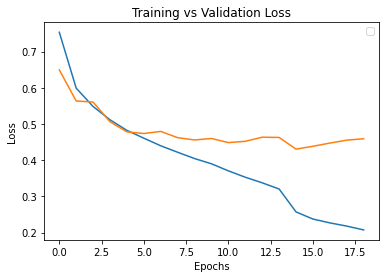

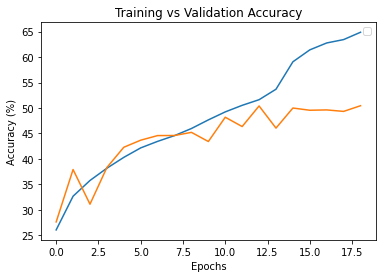

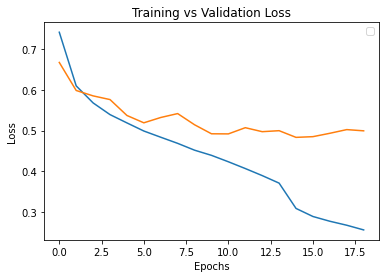

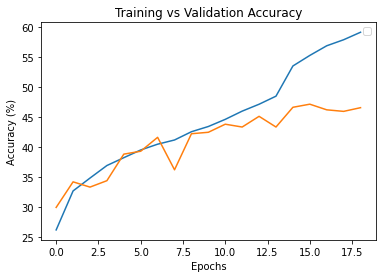

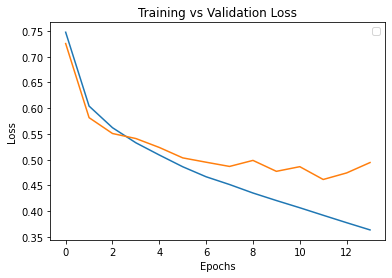

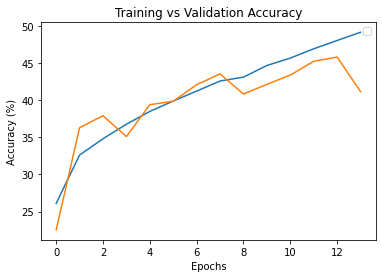

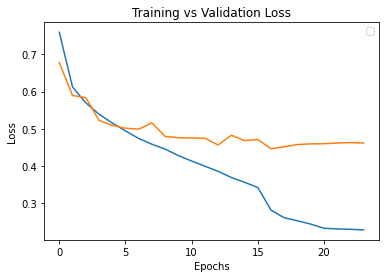

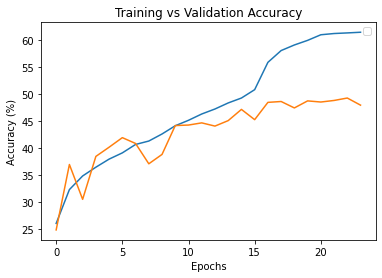

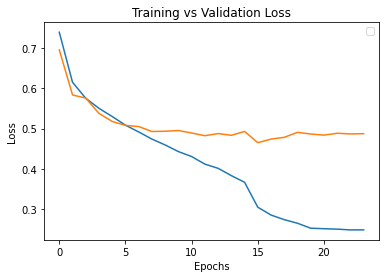

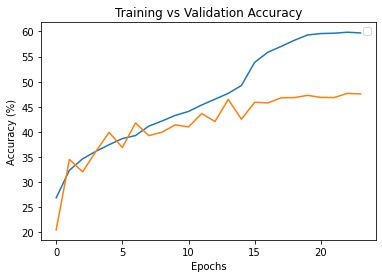

In [3]:
data_directory = r'G:\University Materials\Level 4 Units\FYP\database\Takeout\Drive\Train'
#data_directory = r'G:\University Materials\Level 4 Units\FYP\database\Takeout\Drive\TrainingData'
#data_directory = r'G:\University Materials\Level 4 Units\FYP\training_data'
model_directory = r'G:\University Materials\Level 4 Units\FYP\se_resnet34_plateau\dropout2'
training_code(data_directory, model_directory) ### Implement this function!

print('Done.')

In [4]:
# Test model.
def test_model(model_directory, data_directory, output_directory, limit=None, num_leads=12):
    # Find header and recording files.
    print('Finding header and recording files...')

    header_files, recording_files = find_challenge_files(data_directory)
    num_recordings = len(recording_files)

    if not num_recordings:
        raise Exception('No data was provided.')

    # Create a folder for the outputs if it does not already exist.
    if not os.path.isdir(output_directory):
        os.mkdir(output_directory)
    
    # Load model.
    print('Loading model...')
    leads = range(num_leads)
    model = load_model(model_directory, leads)

    # Run model for each recording.
    print('Running model...')
    
    for i in range(num_recordings):
        if i%100==0:
            print('    {}/{}...'.format(i+1, num_recordings))

        # Load header and recording.
        header = load_header(header_files[i])
        recording = load_recording(recording_files[i])
        
        # Apply model to recording.
        classes, labels, probabilities = run_model(model, header, recording, leads) ### Implement this function!
        if (limit):
            if (len(labels[labels==1]) > limit):
                _, max_ind = torch.topk(probabilities, limit)
                labels = torch.zeros(probabilities.shape[1])
                labels[max_ind] = 1
        probabilities = probabilities.squeeze().tolist()
        labels = labels.squeeze().tolist()
        
        # Save model outputs.
        recording_id = get_recording_id(header)
        head, tail = os.path.split(header_files[i])
        root, extension = os.path.splitext(tail)
        output_file = os.path.join(output_directory, root + '.csv')
        save_outputs(output_file, recording_id, classes, labels, probabilities)
        
    print('Done.')

In [17]:
output_directory = r'G:\University Materials\Level 4 Units\FYP\se_resnet34_plateau\dropout2'
model_directory = r'G:\University Materials\Level 4 Units\FYP\se_resnet34_plateau\dropout2'
data_directory = r'G:\University Materials\Level 4 Units\FYP\database\Takeout\Drive\Test'
leads = [6, 4, 3, 2]
for i in leads:
    new_output_directory = output_directory + f'\\Fold{1}\\{i}Lead'
    new_model_directory = model_directory + f'\\Fold{1}'
    test_model(new_model_directory, data_directory, new_output_directory, limit=None, num_leads=i)

Finding header and recording files...
Loading model...
Running model...
    1/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...


<ipython-input-12-1438affbd72f>:945: RuntimeWarning: invalid value encountered in true_divide
  recording[i, :] = (recording[i, :] - baselines[i]) / adc_gains[i]


Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

<ipython-input-12-1438affbd72f>:969: RuntimeWarning: invalid value encountered in true_divide
  recording_normalized[j,:] = recording_n1/abs(recording_n1).mean()


Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    201/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels.

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    1401/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    2601/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    3801/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    4301/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

    5001/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    5501/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    6701/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    7901/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    8401/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
    9101/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    9601/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    10801/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and label

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    12001/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and label

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    13201/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and label

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    13701/14294...
Extracting features and label

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
    101/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels.

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    601/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels.

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

    1301/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    1801/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    3001/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    4201/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    4701/14294...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    5401/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    5901/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    7101/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    8301/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    9501/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    10001/14294...
Extracting features and label

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    10701/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and label

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    11201/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and label

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    12401/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and label

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    12901/14294...
Extracting features and label

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    13601/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and label

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    14101/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and label

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    1001/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    1501/14294...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    2201/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    2701/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
    3401/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    3901/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    5101/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    5601/14294...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    6301/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    6801/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
    7501/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    8001/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    9201/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    10401/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and label

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    11601/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and label

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    12101/14294...
Extracting features and labels...
Extracting features and label

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    12801/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and label

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    13301/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and label

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    201/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels.

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    1401/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    1901/14294...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
    2601/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    3101/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    4301/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    5501/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    6001/14294

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    6701/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    7201/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    8401/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    9601/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    10101/14294...
Extracting features and labels...
Extracting features and label

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    10801/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and label

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    11301/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and label

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
    12001/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and label

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    12501/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and label

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
    13701/14294...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and label

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting features and labels...
Extracting fea

In [5]:
def evaluate_model(label_directory, output_directory):
    # Identify the weights and the SNOMED CT code for the sinus rhythm class.
    weights_file = 'weights.csv'
    sinus_rhythm = set(['426783006'])
    
    # Load the scored classes and the weights for the Challenge metric.
    print('Loading weights...')
    classes, weights = load_weights(weights_file)
    print(len(classes))
    
    # Load the label and output files.
    print('Loading label and output files...')
    label_files, output_files = find_challenge_files(label_directory, output_directory)
    labels = load_labels(label_files, classes)
    binary_outputs, scalar_outputs = load_classifier_outputs(output_files, classes)

    # Evaluate the model by comparing the labels and outputs.
    print('Evaluating model...')

    print('- AUROC and AUPRC...')
    auroc, auprc, auroc_classes, auprc_classes = compute_auc(labels, scalar_outputs)

    print('- Accuracy...')
    accuracy = compute_accuracy(labels, binary_outputs)

    print('- F-measure...')
    f_measure, f_measure_classes = compute_f_measure(labels, binary_outputs)

    print('- Challenge metric...')
    challenge_metric, cm = compute_challenge_metric(weights, labels, binary_outputs, classes, sinus_rhythm)

    print('Done.')

    # Return the results.
    return classes, auroc, auprc, auroc_classes, auprc_classes, accuracy, f_measure, f_measure_classes, challenge_metric
    #return cm

def challenge_matrix_evaluation(label_directory, output_directory):
    # Identify the weights and the SNOMED CT code for the sinus rhythm class.
    weights_file = 'weights.csv'
    sinus_rhythm = set(['426783006'])
    
    # Load the scored classes and the weights for the Challenge metric.
    print('Loading weights...')
    classes, weights = load_weights(weights_file)
    print(classes)
    
    # Load the label and output files.
    print('Loading label and output files...')
    label_files, output_files = find_challenge_files(label_directory, output_directory)
    labels = load_labels(label_files, classes)
    binary_outputs, scalar_outputs = load_classifier_outputs(output_files, classes)

    # Evaluate the model by comparing the labels and outputs.
    print('Evaluating model...')

    print('- AUROC and AUPRC...')
    auroc, auprc, auroc_classes, auprc_classes = compute_auc(labels, scalar_outputs)

    print('- Accuracy...')
    accuracy = compute_accuracy(labels, binary_outputs)

    print('- F-measure...')
    f_measure, f_measure_classes = compute_f_measure(labels, binary_outputs)

    print('- Challenge metric...')
    challenge_metric, cm = compute_challenge_metric(weights, labels, binary_outputs, classes, sinus_rhythm)

    print('Done.')

    # Return the results.
    #return classes, auroc, auprc, auroc_classes, auprc_classes, accuracy, f_measure, f_measure_classes, challenge_metric
    return cm
    
# Find Challenge files.
def find_challenge_files(label_directory, output_directory):
    label_files = list()
    output_files = list()
    for label_file in sorted(os.listdir(label_directory)):
        label_file_path = os.path.join(label_directory, label_file) # Full path for label file
        if os.path.isfile(label_file_path) and label_file.lower().endswith('.hea') and not label_file.lower().startswith('.'):
            root, ext = os.path.splitext(label_file)
            output_file = root + '.csv'
            output_file_path = os.path.join(output_directory, output_file) # Full path for corresponding output file
            if os.path.isfile(output_file_path):
                label_files.append(label_file_path)
                output_files.append(output_file_path)
            else:
                raise IOError('Output file {} not found for label file {}.'.format(output_file, label_file))

    if label_files and output_files:
        return label_files, output_files
    else:
        raise IOError('No label or output files found.')

# Load a table with row and column names.
def load_table(table_file):
    # The table should have the following form:
    #
    # ,    a,   b,   c
    # a, 1.2, 2.3, 3.4
    # b, 4.5, 5.6, 6.7
    # c, 7.8, 8.9, 9.0
    #
    table = list()
    with open(table_file, 'r') as f:
        for i, l in enumerate(f):
            arrs = [arr.strip() for arr in l.split(',')]
            table.append(arrs)

    # Define the numbers of rows and columns and check for errors.
    num_rows = len(table)-1
    if num_rows<1:
        raise Exception('The table {} is empty.'.format(table_file))
    row_lengths = set(len(table[i])-1 for i in range(num_rows))
    if len(row_lengths)!=1:
        raise Exception('The table {} has rows with different lengths.'.format(table_file))
    num_cols = min(row_lengths)
    if num_cols<1:
        raise Exception('The table {} is empty.'.format(table_file))

    # Find the row and column labels.
    rows = [table[0][j+1] for j in range(num_rows)]
    cols = [table[i+1][0] for i in range(num_cols)]

    # Find the entries of the table.
    values = np.zeros((num_rows, num_cols), dtype=np.float64)
    for i in range(num_rows):
        for j in range(num_cols):
            value = table[i+1][j+1]
            if is_finite_number(value):
                values[i, j] = float(value)
            else:
                values[i, j] = float('nan')

    return rows, cols, values

# Load weights.
def load_weights(weight_file):
    # Load the table with the weight matrix.
    rows, cols, values = load_table(weight_file)

    # Split the equivalent classes.
    rows = [set(row.split('|')) for row in rows]
    cols = [set(col.split('|')) for col in cols]
    assert(rows == cols)

    # Identify the classes and the weight matrix.
    classes = rows
    weights = values

    return classes, weights

# Load labels from header/label files.
def load_labels(label_files, classes):
    # The labels should have the following form:
    #
    # Dx: label_1, label_2, label_3
    #
    num_recordings = len(label_files)
    num_classes = len(classes)

    # Use one-hot encoding for the labels.
    labels = np.zeros((num_recordings, num_classes), dtype=np.bool_)

    # Iterate over the recordings.
    for i in range(num_recordings):
        header = load_header(label_files[i])
        y = set(get_labels(header))
        for j, x in enumerate(classes):
            if x & y:
                labels[i, j] = 1

    return labels

# Load outputs from output files.
def load_classifier_outputs(output_files, classes):
    # The outputs should have the following form:
    #
    # #Record ID
    # diagnosis_1, diagnosis_2, diagnosis_3
    #           0,           1,           1
    #        0.12,        0.34,        0.56
    #
    num_recordings = len(output_files)
    num_classes = len(classes)

    # Use one-hot encoding for the outputs.
    binary_outputs = np.zeros((num_recordings, num_classes), dtype=np.bool_)
    scalar_outputs = np.zeros((num_recordings, num_classes), dtype=np.float64)

    # Iterate over the recordings.
    for i in range(num_recordings):
        recording_id, recording_classes, recording_binary_outputs, recording_scalar_outputs = load_outputs(output_files[i])

        # Allow for equivalent classes and sanitize classifier outputs.
        recording_classes = [set(entry.split('|')) for entry in recording_classes]
        recording_binary_outputs = [1 if ((is_finite_number(entry) and float(entry)==1) or (entry in ('True', 'true', 'T', 't'))) else 0 for entry in recording_binary_outputs]
        recording_scalar_outputs = [float(entry) if is_finite_number(entry) else 0 for entry in recording_scalar_outputs]

        # Allow for unordered/reordered and equivalent classes.
        for j, x in enumerate(classes):
            binary_values = list()
            scalar_values = list()
            for k, y in enumerate(recording_classes):
                if x & y:
                    binary_values.append(recording_binary_outputs[k])
                    scalar_values.append(recording_scalar_outputs[k])
            if binary_values:
                binary_outputs[i, j] = any(binary_values) # Define a class as positive if any of the equivalent classes is positive.
            if scalar_values:
                scalar_outputs[i, j] = np.mean(scalar_values) # Define the scalar value of a class as the mean value of the scalar values across equivalent classes.

    return binary_outputs, scalar_outputs

# Compute recording-wise accuracy.
def compute_accuracy(labels, outputs):
    num_recordings, num_classes = np.shape(labels)

    num_correct_recordings = 0
    for i in range(num_recordings):
        if np.all(labels[i, :]==outputs[i, :]):
            num_correct_recordings += 1

    return float(num_correct_recordings) / float(num_recordings)

# Compute confusion matrices.
def compute_confusion_matrices(labels, outputs, normalize=False):
    # Compute a binary confusion matrix for each class k:
    #
    #     [TN_k FN_k]
    #     [FP_k TP_k]
    #
    # If the normalize variable is set to true, then normalize the contributions
    # to the confusion matrix by the number of labels per recording.
    num_recordings, num_classes = np.shape(labels)

    if not normalize:
        A = np.zeros((num_classes, 2, 2))
        for i in range(num_recordings):
            for j in range(num_classes):
                if labels[i, j]==1 and outputs[i, j]==1: # TP
                    A[j, 1, 1] += 1
                elif labels[i, j]==0 and outputs[i, j]==1: # FP
                    A[j, 1, 0] += 1
                elif labels[i, j]==1 and outputs[i, j]==0: # FN
                    A[j, 0, 1] += 1
                elif labels[i, j]==0 and outputs[i, j]==0: # TN
                    A[j, 0, 0] += 1
                else: # This condition should not happen.
                    raise ValueError('Error in computing the confusion matrix.')
    else:
        A = np.zeros((num_classes, 2, 2))
        for i in range(num_recordings):
            normalization = float(max(np.sum(labels[i, :]), 1))
            for j in range(num_classes):
                if labels[i, j]==1 and outputs[i, j]==1: # TP
                    A[j, 1, 1] += 1.0/normalization
                elif labels[i, j]==0 and outputs[i, j]==1: # FP
                    A[j, 1, 0] += 1.0/normalization 
                elif labels[i, j]==1 and outputs[i, j]==0: # FN
                    A[j, 0, 1] += 1.0/normalization
                elif labels[i, j]==0 and outputs[i, j]==0: # TN
                    A[j, 0, 0] += 1.0/normalization
                else: # This condition should not happen.
                    raise ValueError('Error in computing the confusion matrix.')

    return A

# Compute macro F-measure.
def compute_f_measure(labels, outputs):
    num_recordings, num_classes = np.shape(labels)

    A = compute_confusion_matrices(labels, outputs)

    f_measure = np.zeros(num_classes)
    for k in range(num_classes):
        tp, fp, fn, tn = A[k, 1, 1], A[k, 1, 0], A[k, 0, 1], A[k, 0, 0]
        if 2 * tp + fp + fn:
            f_measure[k] = float(2 * tp) / float(2 * tp + fp + fn)
        else:
            f_measure[k] = float('nan')

    if np.any(np.isfinite(f_measure)):
        macro_f_measure = np.nanmean(f_measure)
    else:
        macro_f_measure = float('nan')

    return macro_f_measure, f_measure

# Compute macro AUROC and macro AUPRC.
def compute_auc(labels, outputs):
    num_recordings, num_classes = np.shape(labels)

    # Compute and summarize the confusion matrices for each class across at distinct output values.
    auroc = np.zeros(num_classes)
    auprc = np.zeros(num_classes)

    for k in range(num_classes):
        # We only need to compute TPs, FPs, FNs, and TNs at distinct output values.
        thresholds = np.unique(outputs[:, k])
        thresholds = np.append(thresholds, thresholds[-1]+1)
        thresholds = thresholds[::-1]
        num_thresholds = len(thresholds)

        # Initialize the TPs, FPs, FNs, and TNs.
        tp = np.zeros(num_thresholds)
        fp = np.zeros(num_thresholds)
        fn = np.zeros(num_thresholds)
        tn = np.zeros(num_thresholds)
        fn[0] = np.sum(labels[:, k]==1)
        tn[0] = np.sum(labels[:, k]==0)

        # Find the indices that result in sorted output values.
        idx = np.argsort(outputs[:, k])[::-1]

        # Compute the TPs, FPs, FNs, and TNs for class k across thresholds.
        i = 0
        for j in range(1, num_thresholds):
            # Initialize TPs, FPs, FNs, and TNs using values at previous threshold.
            tp[j] = tp[j-1]
            fp[j] = fp[j-1]
            fn[j] = fn[j-1]
            tn[j] = tn[j-1]

            # Update the TPs, FPs, FNs, and TNs at i-th output value.
            while i < num_recordings and outputs[idx[i], k] >= thresholds[j]:
                if labels[idx[i], k]:
                    tp[j] += 1
                    fn[j] -= 1
                else:
                    fp[j] += 1
                    tn[j] -= 1
                i += 1

        # Summarize the TPs, FPs, FNs, and TNs for class k.
        tpr = np.zeros(num_thresholds)
        tnr = np.zeros(num_thresholds)
        ppv = np.zeros(num_thresholds)
        for j in range(num_thresholds):
            if tp[j] + fn[j]:
                tpr[j] = float(tp[j]) / float(tp[j] + fn[j])
            else:
                tpr[j] = float('nan')
            if fp[j] + tn[j]:
                tnr[j] = float(tn[j]) / float(fp[j] + tn[j])
            else:
                tnr[j] = float('nan')
            if tp[j] + fp[j]:
                ppv[j] = float(tp[j]) / float(tp[j] + fp[j])
            else:
                ppv[j] = float('nan')

        # Compute AUROC as the area under a piecewise linear function with TPR/
        # sensitivity (x-axis) and TNR/specificity (y-axis) and AUPRC as the area
        # under a piecewise constant with TPR/recall (x-axis) and PPV/precision
        # (y-axis) for class k.
        for j in range(num_thresholds-1):
            auroc[k] += 0.5 * (tpr[j+1] - tpr[j]) * (tnr[j+1] + tnr[j])
            auprc[k] += (tpr[j+1] - tpr[j]) * ppv[j+1]

    # Compute macro AUROC and macro AUPRC across classes.
    if np.any(np.isfinite(auroc)):
        macro_auroc = np.nanmean(auroc)
    else:
        macro_auroc = float('nan')
    if np.any(np.isfinite(auprc)):
        macro_auprc = np.nanmean(auprc)
    else:
        macro_auprc = float('nan')

    return macro_auroc, macro_auprc, auroc, auprc

# Compute a modified confusion matrix for multi-class, multi-label tasks.
def compute_modified_confusion_matrix(labels, outputs):
    # Compute a binary multi-class, multi-label confusion matrix, where the rows
    # are the labels and the columns are the outputs.
    num_recordings, num_classes = np.shape(labels)
    A = np.zeros((num_classes, num_classes))

    # Iterate over all of the recordings.
    for i in range(num_recordings):
        # Calculate the number of positive labels and/or outputs.
        normalization = float(max(np.sum(np.any((labels[i, :], outputs[i, :]), axis=0)), 1))
        # Iterate over all of the classes.
        for j in range(num_classes):
            # Assign full and/or partial credit for each positive class.
            if labels[i, j]:
                for k in range(num_classes):
                    if outputs[i, k]:
                        A[j, k] += 1.0/normalization

    return A

# Compute the evaluation metric for the Challenge.
def compute_challenge_metric(weights, labels, outputs, classes, sinus_rhythm):
    num_recordings, num_classes = np.shape(labels)
    if sinus_rhythm in classes:
        sinus_rhythm_index = classes.index(sinus_rhythm)
    else:
        raise ValueError('The sinus rhythm class is not available.')

    # Compute the observed score.
    A = compute_modified_confusion_matrix(labels, outputs)
    cm = A.copy()
    observed_score = np.nansum(weights * A)

    # Compute the score for the model that always chooses the correct label(s).
    correct_outputs = labels
    A = compute_modified_confusion_matrix(labels, correct_outputs)
    correct_score = np.nansum(weights * A)

    # Compute the score for the model that always chooses the sinus rhythm class.
    inactive_outputs = np.zeros((num_recordings, num_classes), dtype=np.bool_)
    inactive_outputs[:, sinus_rhythm_index] = 1
    A = compute_modified_confusion_matrix(labels, inactive_outputs)
    inactive_score = np.nansum(weights * A)

    if correct_score != inactive_score:
        normalized_score = float(observed_score - inactive_score) / float(correct_score - inactive_score)
    else:
        normalized_score = 0.0

    return normalized_score, cm


In [7]:
#label_directory = r'G:\University Materials\Level 4 Units\FYP\database\TestingData'
#output_directory = r'G:\University Materials\Level 4 Units\FYP\se_resnet34_plateau\dropout2\Fold1\12Lead'
#classes, auroc, auprc, auroc_classes, auprc_classes, accuracy, f_measure, f_measure_classes, challenge_metric = evaluate_model(label_directory, output_directory)
#output_string = 'AUROC,AUPRC,Accuracy,F-measure,Challenge metric\n{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}'.format(auroc, auprc, accuracy, f_measure, challenge_metric)
#class_output_string = 'Classes,{}\nAUROC,{}\nAUPRC,{}\nF-measure,{}'.format(
    #','.join('|'.join(sorted(x)) for x in classes),
    #','.join('{:.3f}'.format(x) for x in auroc_classes),
    #','.join('{:.3f}'.format(x) for x in auprc_classes),
    #','.join('{:.3f}'.format(x) for x in f_measure_classes))

auroc = np.zeros(5)
auprc = np.zeros(5)
accuracy = np.zeros(5)
f_measure = np.zeros(5)
challenge_metric = np.zeros(5)

output_directory = 'G:\\University Materials\\Level 4 Units\\FYP\\se_resnet34_plateau\\dropout2\\'
label_directory = r'G:\University Materials\Level 4 Units\FYP\database\Takeout\Drive\Test'
leads = [6, 4, 3, 2]
count = 0
for i in leads:
    new_output_directory = output_directory + f'\\Fold{1}\\{i}Lead'
    classes, auroc[count], auprc[count], auroc_classes, auprc_classes, accuracy[count], f_measure[count], f_measure_classes, challenge_metric[count] = evaluate_model(label_directory, new_output_directory)
    print(f"AUROC: {auroc[count]}")
    print(f"AUPRC: {auprc[count]}")
    print(f"Accuracy: {accuracy[count]}")
    print(f"F Measure: {f_measure[count]}")
    print(f"Challenge Metric: {challenge_metric[count]}")
    print("----------------------------------------")
    print(f"Auroc Classes: {auroc_classes}")
    count += 1
    
auroc_ave = np.mean(auroc)
auprc_ave = np.mean(auprc)
accuracy_ave = np.mean(accuracy)
f_measure_ave = np.mean(f_measure)
challenge_metric_ave = np.mean(challenge_metric)

print(f"AUROC Average: {auroc_ave}")
print(f"AUPRC Average: {auprc_ave}")
print(f"Accuracy Average: {accuracy_ave}")
print(f"F Measure Average: {f_measure_ave}")
print(f"Challenge Metric Average: {challenge_metric_ave}")

Loading weights...
26
Loading label and output files...
Evaluating model...
- AUROC and AUPRC...
- Accuracy...
- F-measure...
- Challenge metric...
Done.
AUROC: 0.936885411036758
AUPRC: 0.5294687677884803
Accuracy: 0.23170561074576745
F Measure: 0.47209942774739866
Challenge Metric: 0.547997654694721
----------------------------------------
Auroc Classes: [0.97526258 0.95031112 0.9633402  0.94996793 0.98800844 0.9772893
 0.97197438 0.8558237  0.96332417 0.98903711 0.98123502 0.86980282
 0.94491415 0.83974434 0.97747923 0.91975765 0.9676814  0.88202857
 0.91571761 0.85457151 0.97017957 0.95898358 0.98509307 0.99306201
 0.86151625 0.85291495]
Loading weights...
26
Loading label and output files...
Evaluating model...
- AUROC and AUPRC...
- Accuracy...
- F-measure...
- Challenge metric...
Done.
AUROC: 0.9069246793034627
AUPRC: 0.437274493100294
Accuracy: 0.062193927522037215
F Measure: 0.38566303943993147
Challenge Metric: 0.4240217812394291
----------------------------------------
Auroc 

In [ ]:
print(auroc_classes)
print(auprc_classes)
print(f_measure_classes)

In [6]:
def feature_extraction(data_directory, file_directory):
    # Find header and recording files.
    print('Finding header and recording files...')
    
    header_files, recording_files = find_challenge_files_2(data_directory)
    num_recordings = len(recording_files)

    # Extract the classes from the dataset.
    print('Extracting classes...')
    scored_arr = {'164889003':'AF', '164890007': 'AFL', '6374002': 'BBB', '426627000': 'Brady', '733534002': 'CLBBB', 
    '713427006': 'CRBBB', '270492004': 'IAVB', '713426002': 'IRBBB', '39732003': 'LAD', '445118002': 'LAnFB', '164947007': 'LPR',
    '251146004': 'LQRSV', '111975006': 'LQT', '698252002': 'NSIVCB', '426783006': 'NSR', '284470004': 'PAC', '10370003': 'PR', 
    '365413008': 'PRWP', '427172004': 'PVC', '164917005': 'QAb', '47665007': 'RAD', '427393009': 'SA', '426177001': 'SB', 
    '427084000': 'STach', '164934002': 'TAb', '59931005': 'TInv', '164909002': 'LBBB', '59118001': 'RBBB', '63593006': 'SVPB', 
    '17338001': 'VPB'}
    scored_df  = pd.DataFrame(data = np.zeros(60).reshape(30,2),columns=(['Arrhythmia Numerical Code','Arrhythmia Abbrivation']))
    scored_df['Arrhythmia Numerical Code'] = scored_arr.keys()
    scored_df['Arrhythmia Abbrivation'] = scored_arr.values()
    scored_classes = list(scored_arr.keys())
    num_scored_classes = len(scored_classes)

    classes = set()
    for header_file in header_files:
        header = load_header(header_file)
        classes |= set(get_labels(header))
    if all(is_integer(x) for x in classes):
        classes = sorted(classes, key=lambda x: int(x)) # Sort classes numerically if numbers.
    else:
        classes = sorted(classes) # Sort classes alphanumerically if not numbers.
    num_classes = len(classes)
    
    # Extract the features and labels from the dataset.
    print('Extracting features and labels...')
    
    data = np.zeros((1, 14), dtype=np.float32) # 14 features: one feature for each lead, one feature for age, and one feature for sex
    f = h5py.File(file_directory, 'a')
    
    for i in range(num_recordings):
        if (i+1) % 250 == 0:
            print('    {}/{}...'.format(i+1, num_recordings))

        # Load header and recording.
        header = load_header(header_files[i])
        recording = load_recording(recording_files[i])

        # Get age, sex and root mean square of the leads.
        age, sex, rms = get_features(header, recording, twelve_leads)
        if not is_integer(age):
            age = 50
        if not is_integer(sex):
            sex = 0.5
        data[0, 0:12] = rms
        data[0, 12] = age
        data[0, 13] = sex
        
        # Assign target labels
        rlabels = np.zeros((1,num_scored_classes))
        current_labels = get_labels(header)
        for label in current_labels:
            if label in scored_classes:
                j = scored_classes.index(label)
                rlabels[0, j] = 1
        if sum(rlabels.transpose()) == 0:
            continue

        # Amend target labels
        rlabels26 = np.zeros((1,26))
        rlabels26 = rlabels[0,0:26].reshape(1,26)
        if rlabels[0,26]==1:
            rlabels26[0,4]=1
        if rlabels[0,27]==1:
            rlabels26[0,5]=1
        if rlabels[0,28]==1:
            rlabels26[0,15]=1
        if rlabels[0,29]==1:
            rlabels26[0,18]=1
        
        # Chek if all leads are available
        all_leads = 1
        for j in range(12):
            if recording[j,:].mean()==0 and recording[j,:].var()==0:
                all_leads = 0
        if all_leads==0:
            continue
        
        recording_filtered = filter_ecg(recording, header)
        
        # If sampling is at 250Hz, then a 10s fixed window is 2500 samples. Any window smaller than 2500 will be zero padded.
        if recording_filtered.shape[1] >= 2500:
            temp = recording_filtered[:,:2500]
            if np.isnan(temp).all():
                temp = np.ones((12,2500)) # in case of complete corruption
            elif np.isnan(temp).any():
                temp = np.apply_along_axis(interp, 1, temp) # interpolate nan values
            #if not np.isnan(temp).any():
            temp1 = temp[0].flatten()
            r_peaks = np.array(detectors.pan_tompkins_detector(temp[0])) #Take HRV features from one lead
            rr_interval = np.diff(r_peaks)
            if not np.any(rr_interval) or len(rr_interval) < 2:
                rr_interval = np.ones(10)*250 # Take average heartbeat of 1 second times the sampling rate. In case no r_peaks detected.
            
            # Block Print
            #jupyterBlockPrint() ###### Change to blockPrint() for .py version
            with io.capture_output() as captured:
                features = featureExtraction(rr_interval, temp1)
            # Enable Print
            #jupyterEnablePrint() ###### Change to enablePrint() for .py version
            
            features = np.concatenate((features[None,:], data), axis=1)
            if np.isnan(features).any():
                features = interp(features)
            temp = temp[None, None, :, :]
            features = features[None, :, :]
            labels = rlabels26[None, : ,:]
            if i == 0:
                # Create the dataset at first
                f.create_dataset('data', data=temp, compression="gzip", chunks=True, maxshape=(None, None, temp.shape[2],temp.shape[3]))
                f.create_dataset('feat', data=features, compression="gzip", chunks=True, maxshape=(None, features.shape[1], features.shape[2]))
                f.create_dataset('label', data=labels, compression="gzip", chunks=True, maxshape=(None, labels.shape[1], labels.shape[2])) 
            else:
                # Append new data to it
                f['data'].resize((f['data'].shape[0] + temp.shape[0]), axis=0)
                f['data'][-temp.shape[0]:] = temp

                f['feat'].resize((f['feat'].shape[0] + features.shape[0]), axis=0)
                f['feat'][-features.shape[0]:] = features

                f['label'].resize((f['label'].shape[0] + labels.shape[0]), axis=0)
                f['label'][-labels.shape[0]:] = labels

        else:
            temp = np.zeros((12,2500))
            temp[:recording_filtered.shape[0], :recording_filtered.shape[1]] = recording_filtered
            if np.isnan(temp).all():
                temp = np.ones((12,2500)) # in case of complete corruption
            elif np.isnan(temp).any():
                temp = np.apply_along_axis(interp, 1, temp) # interpolate nan values
            temp1 = temp[0].flatten()
            r_peaks = np.array(detectors.pan_tompkins_detector(temp[0])) # Take HRV features from one lead
            rr_interval = np.diff(r_peaks)
            if not np.any(rr_interval):
                rr_interval = np.ones(10)*250 # Take average heartbeat of 1 second times the sampling rate. In case no r_peaks detected.
            
            # Block Print
            #jupyterBlockPrint() ###### Change to blockPrint() for .py version
            with io.capture_output() as captured:
                features = featureExtraction(rr_interval, temp1)
            # Enable Print
            #jupyterEnablePrint() ###### Change to enablePrint() for .py version
            
            features = np.concatenate((features[None, :], data), axis=1)
            if np.isnan(features).any():
                features = interp(features)
            temp = temp[None, None, :, :]
            features = features[None, :, :]
            labels = rlabels26[None, : ,:]
            if i == 0:
                # Create the dataset at first
                f.create_dataset('data', data=temp, compression="gzip", chunks=True, maxshape=(None, None, temp.shape[2],temp.shape[3]))
                f.create_dataset('feat', data=features, compression="gzip", chunks=True, maxshape=(None, features.shape[1], features.shape[2]))
                f.create_dataset('label', data=labels, compression="gzip", chunks=True, maxshape=(None, labels.shape[1], labels.shape[2])) 
            else:
                # Append new data to it
                f['data'].resize((f['data'].shape[0] + temp.shape[0]), axis=0)
                f['data'][-temp.shape[0]:] = temp

                f['feat'].resize((f['feat'].shape[0] + features.shape[0]), axis=0)
                f['feat'][-features.shape[0]:] = features

                f['label'].resize((f['label'].shape[0] + labels.shape[0]), axis=0)
                f['label'][-labels.shape[0]:] = labels

    f.close()

In [8]:
# Find header and recording files.
def find_challenge_files_2(data_directory):
    header_files = list()
    recording_files = list()
    for f in os.listdir(data_directory):
        root, extension = os.path.splitext(f)
        if not root.startswith('.') and extension=='.hea':
            header_file = os.path.join(data_directory, root + '.hea')
            recording_file = os.path.join(data_directory, root + '.mat')
            if os.path.isfile(header_file) and os.path.isfile(recording_file):
                header_files.append(header_file)
                recording_files.append(recording_file)
    return header_files, recording_files

data_directory = r'G:\University Materials\Level 4 Units\FYP\database\Takeout\Drive\Test'
file_directory = r'G:\University Materials\Level 4 Units\FYP\TestFeatures\Dataset.h5'
feature_extraction(data_directory, file_directory)

Finding header and recording files...
Extracting classes...
Extracting features and labels...


<ipython-input-3-1438affbd72f>:945: RuntimeWarning: invalid value encountered in true_divide
  recording[i, :] = (recording[i, :] - baselines[i]) / adc_gains[i]


    250/14294...
    500/14294...
    750/14294...
    1000/14294...
    1250/14294...
    1500/14294...
    1750/14294...
    2000/14294...
    2250/14294...
    2500/14294...
    2750/14294...
    3000/14294...
    3250/14294...
    3500/14294...
    3750/14294...
    4000/14294...
    4250/14294...
    4500/14294...
    4750/14294...
    5000/14294...
    5250/14294...
    5500/14294...
    5750/14294...
    6000/14294...
    6250/14294...
    6500/14294...
    6750/14294...
    7000/14294...
    7250/14294...
    7500/14294...
    7750/14294...
    8000/14294...
    8250/14294...
    8500/14294...
    8750/14294...
    9000/14294...
    9250/14294...
    9500/14294...
    9750/14294...
    10000/14294...
    10250/14294...
    10500/14294...
    10750/14294...


E:\Anaconda\envs\FYP\lib\site-packages\scipy\signal\filter_design.py:1630: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


    11000/14294...
    11250/14294...
    11500/14294...
    11750/14294...
    12000/14294...
    12250/14294...
    12500/14294...
    12750/14294...
    13000/14294...
    13250/14294...
    13500/14294...
    13750/14294...
    14000/14294...
    14250/14294...


In [19]:
# Test 'Top-1' model.
def test_top1(model_directory, file_directory, leads):
    sigmoid = nn.Sigmoid()
    with h5py.File(file_directory, 'r') as hf:
        features = hf['feat'][:]
        ecg_data = hf['data'][:]
        labels = hf['label'][:]

    with h5py.File('feature_data.h5', 'r') as hf:
        feature_max = hf['feature_max'][:]
        feature_min = hf['feature_min'][:]
        del_index = hf['del_index'][:]
    
    temp = np.zeros((features.shape[0], features.shape[1], len(feature_max)))
    for i in range(features.shape[0]):
        temp[i][0] = np.delete(features[i][0], del_index)
    features = temp
    
    #### Normalize the training data ####
    for i in range(features.shape[0]):     
        for j in range(feature_max.shape[0]):
            if (feature_max[j]-feature_min[j]) == 0:
                features[i][0][j] = 1
            else:
                features[i][0][j] = (features[i][0][j]-feature_min[j])/(feature_max[j]-feature_min[j])
            
    correct = 0
    total = 0
    labels = labels.squeeze()
    model = load_model(model_directory, leads) ### Implement this function!
    model.to(device)
    model.eval()
    for i in range(ecg_data.shape[0]):
        if i%100==0:
            print('    {}/{}...'.format(i+1, ecg_data.shape[0]))
        
        data = ecg_data[i]
        data = torch.FloatTensor(data[None, :])
        data = data[:, :, leads, :]
        feature_data = features[i]
        feature_data = torch.FloatTensor(feature_data[None, :])
        probabilities = run(model, device, data, feature_data)
        probabilities = sigmoid(probabilities)
        predicted = np.argmax(probabilities.detach().cpu().numpy().flatten())
        label = np.where(labels[i]==1)[0]
        if predicted in label:
            correct += 1
        total += 1
        
    print(f'Accuracy: {(correct/total)*100}%')
    print('Done.')
    return (correct/total)*100

In [25]:
file_directory = r'G:\University Materials\Level 4 Units\FYP\TestFeatures\Dataset.h5'
model_directory = r'G:\University Materials\Level 4 Units\FYP\se_resnet34_plateau\dropout2\Fold1'

leads = [0, 1, 2, 3, 4, 5]
#top1 = np.zeros(5)

top1 = test_top1(model_directory, file_directory, leads)

#top1_average = np.mean(top1)
print(top1)

    1/13819...
    101/13819...
    201/13819...
    301/13819...
    401/13819...
    501/13819...
    601/13819...
    701/13819...
    801/13819...
    901/13819...
    1001/13819...
    1101/13819...
    1201/13819...
    1301/13819...
    1401/13819...
    1501/13819...
    1601/13819...
    1701/13819...
    1801/13819...
    1901/13819...
    2001/13819...
    2101/13819...
    2201/13819...
    2301/13819...
    2401/13819...
    2501/13819...
    2601/13819...
    2701/13819...
    2801/13819...
    2901/13819...
    3001/13819...
    3101/13819...
    3201/13819...
    3301/13819...
    3401/13819...
    3501/13819...
    3601/13819...
    3701/13819...
    3801/13819...
    3901/13819...
    4001/13819...
    4101/13819...
    4201/13819...
    4301/13819...
    4401/13819...
    4501/13819...
    4601/13819...
    4701/13819...
    4801/13819...
    4901/13819...
    5001/13819...
    5101/13819...
    5201/13819...
    5301/13819...
    5401/13819...
    5501/13819...
    

In [10]:
# Find header and recording files.
def find_challenge_files_2(data_directory):
    header_files = list()
    recording_files = list()
    for f in os.listdir(data_directory):
        root, extension = os.path.splitext(f)
        if not root.startswith('.') and extension=='.hea':
            header_file = os.path.join(data_directory, root + '.hea')
            recording_file = os.path.join(data_directory, root + '.mat')
            if os.path.isfile(header_file) and os.path.isfile(recording_file):
                header_files.append(header_file)
                recording_files.append(recording_file)
    return header_files, recording_files

# Test optimal class thresholds.
def test_thresholds(output_directory, label_directory):
    _, output_files = find_challenge_files(label_directory, output_directory)
    
    thresholds = np.ones(26)*0.5
    final_thresholds = np.zeros(26)
    for i in range(len(thresholds)):
        custom_threshold = thresholds.copy()
        custom_threshold[i] = 0.1
        best_threshold = 0
        best_metric = 0
        while(custom_threshold[i] <= 0.9):
            #Compute challenge metric
            #Loop over the list of csv files
            for f in output_files:
                recording_id, classes, _, probabilities = load_outputs(f)
                classes = list(classes)
                probabilities = np.array(probabilities)
                labels = list(np.greater_equal(probabilities, custom_threshold).astype(float))
                head, tail = os.path.split(f)
                root, extension = os.path.splitext(tail)
                output_file = os.path.join(output_directory, root + '.csv')
                save_outputs(output_file, root, classes, labels, probabilities)
            
            with io.capture_output() as captured:
                _, _, _, _, _, _, _, _, challenge_metric = evaluate_model(label_directory, output_directory)
            print(f'Challenge metric for class {i+1} custom threshold {custom_threshold[i]}: {challenge_metric}')
            
            #If new threshold performs better, update
            if (challenge_metric > best_metric):
                best_metric = challenge_metric
                best_threshold = custom_threshold[i]
                
            #Increment threshold by step-size
            custom_threshold[i] += 0.1
            custom_threshold[i] = np.around(custom_threshold[i], 2)
            
        custom_threshold[i] = best_threshold - 0.05
        optimize_threshold = 0
        optimize_metric = 0
        while(custom_threshold[i] <= (best_threshold + 0.05)):
            if (custom_threshold[i] != best_threshold):
                #Compute challenge metric
                #Loop over the list of csv files
                for f in output_files:
                    recording_id, classes, _, probabilities = load_outputs(f)
                    classes = list(classes)
                    probabilities = np.array(probabilities)
                    labels = list(np.greater_equal(probabilities, custom_threshold).astype(float))
                    head, tail = os.path.split(f)
                    root, extension = os.path.splitext(tail)
                    output_file = os.path.join(output_directory, root + '.csv')
                    save_outputs(output_file, root, classes, labels, probabilities)
                    
                with io.capture_output() as captured:
                    _, _, _, _, _, _, _, _, challenge_metric = evaluate_model(label_directory, output_directory)
                print(f'Challenge metric for class {i+1} optimize threshold {custom_threshold[i]}: {challenge_metric}')
                
                #If new threshold performs better, update
                if (challenge_metric > optimize_metric):
                    optimize_metric = challenge_metric
                    optimize_threshold = custom_threshold[i]
            else:
                if (best_metric > optimize_metric):
                    optimize_metric = best_metric
                    optimize_threshold = best_threshold
                
            #Increment threshold by step-size
            custom_threshold[i] += 0.01
            custom_threshold[i] = np.around(custom_threshold[i], 2)
        
        final_thresholds[i] = optimize_threshold
    
    print(f'Final Thresholds: {final_thresholds}')
    
    _, _, _, _, _, accuracy, _, _, challenge_metric = evaluate_model(label_directory, output_directory)
    print(f'Final threshold accuracy: {accuracy}, challenge metric: {challenge_metric}')
    
    print('Done.')
    

In [11]:
# Find header and recording files.
def find_challenge_files_2(data_directory):
    header_files = list()
    recording_files = list()
    for f in os.listdir(data_directory):
        root, extension = os.path.splitext(f)
        if not root.startswith('.') and extension=='.hea':
            header_file = os.path.join(data_directory, root + '.hea')
            recording_file = os.path.join(data_directory, root + '.mat')
            if os.path.isfile(header_file) and os.path.isfile(recording_file):
                header_files.append(header_file)
                recording_files.append(recording_file)
    return header_files, recording_files

def validate2(net,device, loader, Loss_fun, thresholds):
    epoch_loss = 0
    correct = 0
    accuracy = 0
    total = 0
    sigmoid = nn.Sigmoid()
    #Set network into evaluation mode
    net.eval()
    
    with torch.no_grad():
        for idx, (data,feat,y) in enumerate(loader):
            data, feat, y = data.to(device), feat.to(device), y.to(device)
            y = y.squeeze(dim=1)
            output = net(data, feat)
            loss = Loss_fun(output,y)
            epoch_loss += loss.item()
            total += y.size(0) # sums the number of predictions
            output = sigmoid(output).detach().cpu().numpy()
            output = np.greater_equal(output, thresholds).astype(float)
            accuracy += accuracy_score(y.cpu().numpy(), output, normalize=False)
        return epoch_loss/len(loader), (accuracy/total)*100

In [24]:
label_directory = r'G:\University Materials\Level 4 Units\FYP\database\Takeout\Drive\Test'
output_directory = 'G:\\University Materials\\Level 4 Units\\FYP\\se_resnet34_plateau\\dropout2\\12Lead_Threshold\\Fold1\\12Lead'
test_thresholds(output_directory, label_directory)

Challenge metric for class 1 custom threshold 0.1: 0.5680530934706107
Challenge metric for class 1 custom threshold 0.2: 0.5653831593729485
Challenge metric for class 1 custom threshold 0.3: 0.5633913674946464
Challenge metric for class 1 custom threshold 0.4: 0.5566121586613243
Challenge metric for class 1 custom threshold 0.5: 0.5550475569357695
Challenge metric for class 1 custom threshold 0.6: 0.5533363970654738
Challenge metric for class 1 custom threshold 0.7: 0.5510521395442817
Challenge metric for class 1 custom threshold 0.8: 0.5479839995662539
Challenge metric for class 1 custom threshold 0.9: 0.543447569533914
Challenge metric for class 1 optimize threshold 0.05: 0.5694169300572688
Challenge metric for class 1 optimize threshold 0.06: 0.5690281077207152
Challenge metric for class 1 optimize threshold 0.07: 0.5687084165845112
Challenge metric for class 1 optimize threshold 0.08: 0.568267359526282
Challenge metric for class 1 optimize threshold 0.09: 0.5681553669817162
Challen

Challenge metric for class 7 custom threshold 0.2: 0.55761537437463
Challenge metric for class 7 custom threshold 0.3: 0.5569586076386048
Challenge metric for class 7 custom threshold 0.4: 0.555839373504948
Challenge metric for class 7 custom threshold 0.5: 0.5550475569357695
Challenge metric for class 7 custom threshold 0.6: 0.553813168521766
Challenge metric for class 7 custom threshold 0.7: 0.5518240808933597
Challenge metric for class 7 custom threshold 0.8: 0.5477855930212511
Challenge metric for class 7 custom threshold 0.9: 0.5428897156031617
Challenge metric for class 7 optimize threshold 0.15000000000000002: 0.55771697981111
Challenge metric for class 7 optimize threshold 0.16: 0.5575909170340021
Challenge metric for class 7 optimize threshold 0.17: 0.5574863865925327
Challenge metric for class 7 optimize threshold 0.18: 0.5575684058238043
Challenge metric for class 7 optimize threshold 0.19: 0.5576235074570239
Challenge metric for class 7 optimize threshold 0.21: 0.5573869160

Challenge metric for class 13 custom threshold 0.2: 0.5573368163026338
Challenge metric for class 13 custom threshold 0.3: 0.5569687129934792
Challenge metric for class 13 custom threshold 0.4: 0.5559467098598432
Challenge metric for class 13 custom threshold 0.5: 0.5550475569357695
Challenge metric for class 13 custom threshold 0.6: 0.5539573375735533
Challenge metric for class 13 custom threshold 0.7: 0.5524762626041853
Challenge metric for class 13 custom threshold 0.8: 0.551523228009251
Challenge metric for class 13 custom threshold 0.9: 0.5488830261370833
Challenge metric for class 13 optimize threshold 0.05: 0.5571844430039818
Challenge metric for class 13 optimize threshold 0.06: 0.5574623097639745
Challenge metric for class 13 optimize threshold 0.07: 0.5575683564443761
Challenge metric for class 13 optimize threshold 0.08: 0.5580358053549738
Challenge metric for class 13 optimize threshold 0.09: 0.5581548940139285
Challenge metric for class 13 optimize threshold 0.11: 0.558133

Challenge metric for class 19 custom threshold 0.1: 0.5574914261989448
Challenge metric for class 19 custom threshold 0.2: 0.5565340316909126
Challenge metric for class 19 custom threshold 0.3: 0.5561704654798648
Challenge metric for class 19 custom threshold 0.4: 0.5557893434295352
Challenge metric for class 19 custom threshold 0.5: 0.5550475569357695
Challenge metric for class 19 custom threshold 0.6: 0.5548315016019715
Challenge metric for class 19 custom threshold 0.7: 0.5542781673412924
Challenge metric for class 19 custom threshold 0.8: 0.5537974818390985
Challenge metric for class 19 custom threshold 0.9: 0.552613305042525
Challenge metric for class 19 optimize threshold 0.05: 0.5575942196463886
Challenge metric for class 19 optimize threshold 0.06: 0.5577982176855372
Challenge metric for class 19 optimize threshold 0.07: 0.5575045146522546
Challenge metric for class 19 optimize threshold 0.08: 0.5575739101777817
Challenge metric for class 19 optimize threshold 0.09: 0.557475255

Challenge metric for class 24 optimize threshold 0.15: 0.5773094620161507
Challenge metric for class 25 custom threshold 0.1: 0.5622796855089287
Challenge metric for class 25 custom threshold 0.2: 0.564222083435048
Challenge metric for class 25 custom threshold 0.3: 0.5620408110696703
Challenge metric for class 25 custom threshold 0.4: 0.5590288024311861
Challenge metric for class 25 custom threshold 0.5: 0.5550475569357695
Challenge metric for class 25 custom threshold 0.6: 0.5482944611062766
Challenge metric for class 25 custom threshold 0.7: 0.5418761345668116
Challenge metric for class 25 custom threshold 0.8: 0.5328313133036854
Challenge metric for class 25 custom threshold 0.9: 0.5219698170448902
Challenge metric for class 25 optimize threshold 0.15000000000000002: 0.5649870927837213
Challenge metric for class 25 optimize threshold 0.16: 0.5649971778058902
Challenge metric for class 25 optimize threshold 0.17: 0.5648775982573193
Challenge metric for class 25 optimize threshold 0.

FileNotFoundError: [Errno 2] Unable to create file (unable to open file: name = 'G:\University Materials\Level 4 Units\FYP\se_resnet34_plateau\dropout2\12Lead_Threshold\Fold1\12Lead\optimized\thresholds.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

In [31]:
auroc = np.zeros(5)
auprc = np.zeros(5)
accuracy = np.zeros(5)
f_measure = np.zeros(5)
challenge_metric = np.zeros(5)

label_directory = r'G:\University Materials\Level 4 Units\FYP\database\Takeout\Drive\Test'
output_directory = 'G:\\University Materials\\Level 4 Units\\FYP\\se_resnet34_plateau\\dropout2\\'

custom_threshold = [0.05, 0.26, 0.2, 0.07, 0.17, 0.05, 0.15, 0.13, 0.12, 0.05, 0.1, 0.24, 0.09, 0.22,
     0.23, 0.23, 0.2, 0.06, 0.06, 0.46, 0.07, 0.05, 0.15, 0.05, 0.16, 0.14]

for i in range(5):
    new_output_directory = output_directory + f'Fold{i+1}\\12Lead'

    _, output_files = find_challenge_files(label_directory, new_output_directory)
    for f in output_files:
        recording_id, classes, _, probabilities = load_outputs(f)
        classes = list(classes)
        probabilities = np.array(probabilities)
        labels = list(np.greater_equal(probabilities, custom_threshold).astype(float))
        head, tail = os.path.split(f)
        root, extension = os.path.splitext(tail)
        output_file = os.path.join(output_directory, root + '.csv')
        save_outputs(output_file, root, classes, labels, probabilities)

    with io.capture_output() as captured:
        classes, auroc[i], auprc[i], auroc_classes, auprc_classes, accuracy[i], f_measure[i], f_measure_classes, challenge_metric[i] = evaluate_model(label_directory, new_output_directory)

auroc_ave = np.mean(auroc)
auprc_ave = np.mean(auprc)
accuracy_ave = np.mean(accuracy)
f_measure_ave = np.mean(f_measure)
challenge_metric_ave = np.mean(challenge_metric)

print(f"AUROC Average: {auroc_ave}")
print(f"AUPRC Average: {auprc_ave}")
print(f"Accuracy Average: {accuracy_ave}")
print(f"F Measure Average: {f_measure_ave}")
print(f"Challenge Metric Average: {challenge_metric_ave}")

AUROC Average: 0.9516671889081195
AUPRC Average: 0.576228407996636
Accuracy Average: 0.3064782426192808
F Measure Average: 0.5190237588469715
Challenge Metric Average: 0.5990911378939793


In [32]:
label_directory = r'G:\University Materials\Level 4 Units\FYP\database\Takeout\Drive\Test'
output_directory = 'G:\\University Materials\\Level 4 Units\\FYP\\se_resnet34_plateau\\dropout2\\'
cm = []
for i in range(5):
    new_output_directory = output_directory + f'Fold{i+1}\\12Lead'
    cm.append(challenge_matrix_evaluation(label_directory, new_output_directory))

cm_average = np.add(cm[0], cm[1])
cm_average = np.add(cm_average, cm[2])
cm_average = np.add(cm_average, cm[3])
cm_average = np.add(cm_average, cm[4])
cm_average /= 5

Loading weights...
[{'164889003'}, {'164890007'}, {'6374002'}, {'426627000'}, {'733534002', '164909002'}, {'59118001', '713427006'}, {'270492004'}, {'713426002'}, {'39732003'}, {'445118002'}, {'164947007'}, {'251146004'}, {'111975006'}, {'698252002'}, {'426783006'}, {'63593006', '284470004'}, {'10370003'}, {'365413008'}, {'427172004', '17338001'}, {'164917005'}, {'47665007'}, {'427393009'}, {'426177001'}, {'427084000'}, {'164934002'}, {'59931005'}]
Loading label and output files...
Evaluating model...
- AUROC and AUPRC...
- Accuracy...
- F-measure...
- Challenge metric...
Done.
Loading weights...
[{'164889003'}, {'164890007'}, {'6374002'}, {'426627000'}, {'733534002', '164909002'}, {'59118001', '713427006'}, {'270492004'}, {'713426002'}, {'39732003'}, {'445118002'}, {'164947007'}, {'251146004'}, {'111975006'}, {'698252002'}, {'426783006'}, {'63593006', '284470004'}, {'10370003'}, {'365413008'}, {'427172004', '17338001'}, {'164917005'}, {'47665007'}, {'427393009'}, {'426177001'}, {'4270

In [33]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    if not normalize:
        cm = cm.astype(int)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[3.63454481e-01 1.25828318e-01 2.81452395e-03 6.13309631e-04
  1.46469064e-02 4.12747589e-02 3.05894648e-03 2.60824139e-02
  5.53025552e-02 2.17140457e-02 5.82255978e-05 9.24876128e-03
  1.44178269e-02 3.06468155e-02 2.24456445e-02 4.91391698e-03
  1.66355385e-03 1.29029983e-02 5.30596934e-03 2.90090956e-02
  9.15614435e-03 3.12606765e-03 1.43526099e-03 6.54488067e-03
  1.55265158e-01 3.90694203e-02]
 [1.38376502e-01 2.87050941e-01 3.43567265e-03 0.00000000e+00
  3.82304178e-03 2.19760757e-02 7.34002030e-03 4.85211080e-02
  3.77046788e-02 5.31495443e-03 0.00000000e+00 3.05258540e-02
  5.75199845e-02 1.26475606e-02 1.63597231e-02 4.49473153e-03
  1.53947991e-03 1.76346258e-02 3.38502309e-03 3.13414951e-02
  1.63817157e-02 4.05762920e-03 1.98208039e-03 3.85309829e-02
  1.54251555e-01 5.58045640e-02]
 [2.37088721e-02 1.55856884e-02 1.76652429e-01 0.00000000e+00
  2.35362667e-01 4.68326410e-02 7.00319856e-02 2.37941997e-02
  1.17232754e-01 1.21213894e-02 0.0000

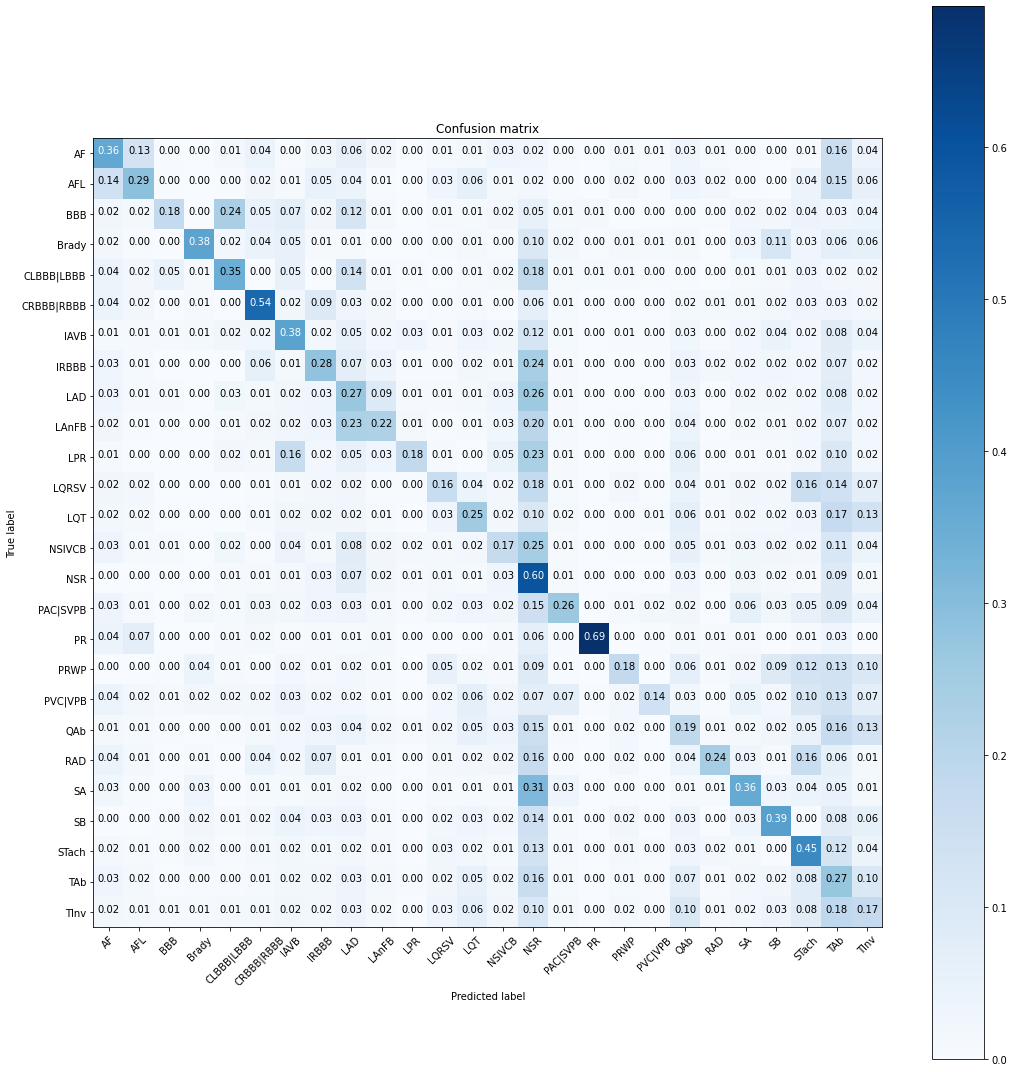

In [34]:
classes = ['AF', 'AFL', 'BBB', 'Brady', 'CLBBB|LBBB', 'CRBBB|RBBB', 'IAVB', 'IRBBB', 'LAD', 'LAnFB', 'LPR', 'LQRSV', 
               'LQT','NSIVCB', 'NSR', 'PAC|SVPB', 'PR', 'PRWP', 'PVC|VPB', 'QAb', 'RAD', 'SA', 'SB', 'STach', 'TAb',
               'TInv']
plt.figure(figsize=(15,15))
plot_confusion_matrix(cm_average, classes, normalize=True)

In [ ]:
import shutil

def feature_extraction(data_directory):
    # Find header and recording files.
    print('Finding header and recording files...')

    header_files, recording_files = find_challenge_files_2(data_directory)
    num_recordings = len(recording_files)

    # Extract the classes from the dataset.
    print('Extracting classes...')
    scored_arr = {'164889003':'AF', '164890007': 'AFL', '6374002': 'BBB', '426627000': 'Brady', '733534002': 'CLBBB', 
    '713427006': 'CRBBB', '270492004': 'IAVB', '713426002': 'IRBBB', '39732003': 'LAD', '445118002': 'LAnFB', '164947007': 'LPR',
    '251146004': 'LQRSV', '111975006': 'LQT', '698252002': 'NSIVCB', '426783006': 'NSR', '284470004': 'PAC', '10370003': 'PR', 
    '365413008': 'PRWP', '427172004': 'PVC', '164917005': 'QAb', '47665007': 'RAD', '427393009': 'SA', '426177001': 'SB', 
    '427084000': 'STach', '164934002': 'TAb', '59931005': 'TInv', '164909002': 'LBBB', '59118001': 'RBBB', '63593006': 'SVPB', 
    '17338001': 'VPB'}
    scored_df  = pd.DataFrame(data = np.zeros(60).reshape(30,2),columns=(['Arrhythmia Numerical Code','Arrhythmia Abbrivation']))
    scored_df['Arrhythmia Numerical Code'] = scored_arr.keys()
    scored_df['Arrhythmia Abbrivation'] = scored_arr.values()
    scored_classes = list(scored_arr.keys())
    num_scored_classes = len(scored_classes)

    classes = set()
    for header_file in header_files:
        header = load_header(header_file)
        classes |= set(get_labels(header))
    if all(is_integer(x) for x in classes):
        classes = sorted(classes, key=lambda x: int(x)) # Sort classes numerically if numbers.
    else:
        classes = sorted(classes) # Sort classes alphanumerically if not numbers.
    num_classes = len(classes)
    
    # Extract the features and labels from the dataset.
    print('Extracting features and labels...')
    
    data = np.zeros((1, 14), dtype=np.float32) # 14 features: one feature for each lead, one feature for age, and one feature for sex
    count = 0
    
    for i in range(num_recordings):
        if (i+1) % 250 == 0:
            print('    {}/{}...'.format(i+1, num_recordings))

        # Load header and recording.
        header = load_header(header_files[i])
        recording = load_recording(recording_files[i])
        #print(header_files[i])
        #print(recording_files[i])
        
        # Get age, sex and root mean square of the leads.
        age, sex, rms = get_features(header, recording, twelve_leads)
        if not is_integer(age):
            age = 50
        if not is_integer(sex):
            sex = 0.5
        data[0, 0:12] = rms
        data[0, 12] = age
        data[0, 13] = sex
        
        '''
        # Assign target labels
        current_labels = get_labels(header)
        for label in current_labels:
            if label in scored_classes:
                j = scored_classes.index(label)
                if j == 23:
                    count += 1
                    #if (count % 2 == 0):
                        #rec_id = get_recording_id(header)
                        #dst_path_hea = 'G:\\University Materials\\Level 4 Units\\FYP\\database\\ningbo\\STach\\' + rec_id + '.hea'
                        #dst_path_mat = 'G:\\University Materials\\Level 4 Units\\FYP\\database\\ningbo\\STach\\' + rec_id + '.mat'
                        #shutil.move(header_files[i], dst_path_hea)
                        #shutil.move(recording_files[i], dst_path_mat)
        '''
        rec_id = get_recording_id(header)
        if i < 500:
            dst_path_hea = 'G:\\University Materials\\Level 4 Units\\FYP\\database\\Takeout\\Drive\\Train\\' + rec_id + '.hea'
            dst_path_mat = 'G:\\University Materials\\Level 4 Units\\FYP\\database\\Takeout\\Drive\\Train\\' + rec_id + '.mat'
            shutil.move(header_files[i], dst_path_hea)
            shutil.move(recording_files[i], dst_path_mat)
        else:
            dst_path_hea = 'G:\\University Materials\\Level 4 Units\\FYP\\database\\Takeout\\Drive\\Test\\' + rec_id + '.hea'
            dst_path_mat = 'G:\\University Materials\\Level 4 Units\\FYP\\database\\Takeout\\Drive\\Test\\' + rec_id + '.mat'
            shutil.move(header_files[i], dst_path_hea)
            shutil.move(recording_files[i], dst_path_mat)
            
    print(count)
    
data_directory = r'G:\University Materials\Level 4 Units\FYP\database\ningbo\PRWP'
feature_extraction(data_directory)